In [1]:
import os
import pandas as pd
import numpy as np
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D # 3d plot
from matplotlib import cm #color map
from matplotlib.ticker import FormatStrFormatter # set decimals in ticks
from matplotlib import rc,re
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from LBL_funcs_plotting import make_cmap

from scipy.ndimage import gaussian_filter1d

# from scope_sw import * # when send the processing part of code to other, update the func.py.
from fun_nearealtime_RTM import *

Sun_Zen=0
local_zen=20
rela_azi=20
COD_guess=15
T_a=299
RH=61
channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
data_dir = './GOES_data/'

In [3]:
COD_v = np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
COD_v

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 25., 30.,
       35., 40., 45., 50.])

### Run cases

In [15]:
from fun_nearealtime_RTM import nearealtime_RTM

def nearealtime_RTM(sun_zen, local_zen, rela_azi, COD_guess, T_a, RH, channels, file_dir, bandmode, N_bundles):
    # Round values to two decimal places
    sun_zen = round(sun_zen)
    local_zen = round(local_zen)
    rela_azi = round(rela_azi)
    COD_guess = round(COD_guess)
    T_a = round(T_a)
    RH = round(RH)
    
    uw_rxyz_file = f"uwxyzr_COD={COD_guess}_th0={sun_zen}_Ta={T_a}_RH={RH}.npy"
    if N_bundles == 1000:
        if bandmode == 'GOES':
            uw_rxyz_path = os.path.join(file_dir, 'RTM/channels', uw_rxyz_file)
        else:
            uw_rxyz_path = os.path.join(file_dir, 'RTM/fullspectrum', uw_rxyz_file)
    if N_bundles == 10000:
        if sys.platform != 'darwin':
            file_dir='/mnt/dengnan/'
        if bandmode == 'FY4A':
            uw_rxyz_path = os.path.join(file_dir, 'RTM_10000/channels', uw_rxyz_file)
        else:
            uw_rxyz_path = os.path.join(file_dir, 'RTM_10000/fullspectrum', uw_rxyz_file)

    if not os.path.exists(uw_rxyz_path):
        print(f"File {uw_rxyz_file} not found. Running RTM...")
        run_RTM(sun_zen, COD_guess, T_a, RH, file_dir, channels, bandmode, N_bundles)

channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
COD_v = np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
Sun_Zen_v = np.array([10,20,25,35,40]) # 0,15,30,45,60
T_a = 294#+10
rh0_v = np.array([60])#/100
N_bundles = 10000
bandmode = "FY4A"
for Sun_Zen in Sun_Zen_v:
    for iCOD in COD_v:
        COD_guess = iCOD
        for RH in rh0_v:
            nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, 
                                     channels, file_dir=data_dir, bandmode=bandmode, N_bundles=N_bundles)

File uwxyzr_COD=50_th0=10_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 146.70819282531738
File uwxyzr_COD=0_th0=20_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 58.268234968185425
File uwxyzr_COD=2_th0=20_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 59.990214586257935
File uwxyzr_COD=4_th0=20_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 61.61550188064575
File uwxyzr_COD=6_th0=20_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 62.138619899749756
File uwxyzr_COD=8_th0=20_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 67.66680121421814
File uwxyzr_COD=10_th0=20_Ta=294_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 67.4229097366333
File uwxyzr_COD=12_th0=20_Ta=294_RH=60.npy not fou

### func : cal_moni_intensity

In [1]:
def cal_mono_R(rxyz_M, theta0, nu, F_dw_os, local_zen, rela_azi, N_bundles=1000,
                       is_flux=False, Norm=False, dirc='UW', bin_scale=1):  # Z_csky
    """
    bins_theta: local zenith angle
    bin_phi: relative difference between the angle of solar azimuth and local zimuth
    solid anlge (bin_theta,bin_phi) determined to the intensity at an angle of (satellite local solar).
    rxyz_M : the vector of each photon fall on the ground. Each band saved many photons, 
            we sum the number of photon, multiple with ratio to get  the flux.
    F_dw_os: the downwelling flux at TOA on each nu
    """
    theta0 = theta0 / 180 * math.pi
    phi0 = 0 / 180 * math.pi

    # bin_scale = 1
    d_th = 2 * bin_scale
    d_phi = 5 * bin_scale
    # GOES solar zenith 45, local zenith angle 45, relative azimuth difference angle 45
    bins_theta = np.arange(0, 91, d_th)
    # symmetric, so we change (-180, 180) to (0, 180)
    bins_phi = np.arange(-180, 181, d_phi)
    #bins_phi = np.hstack((np.arange(0, 170 + 5, 5), np.arange(170, 180 + 1, 1)))
    fw_rx, fw_ry, fw_rz, uw_rx, uw_ry, uw_rz = [np.zeros((N_bundles + 10, len(nu))) * np.nan for _ in range(6)]
    H = np.zeros((len(bins_theta) - 1, len(bins_phi) - 1))
    for i in range(len(rxyz_M)):
        fw_rxyz = rxyz_M[i]
        N_dw = len(fw_rxyz)
        fw_rx[0:N_dw, i] = np.array([x[0] for x in fw_rxyz])
        fw_ry[0:N_dw, i] = np.array([x[1] for x in fw_rxyz])
        fw_rz[0:N_dw, i] = np.array([x[2] for x in fw_rxyz])
        if dirc == 'UW':
            theta_v, phi_v = theta_phi(fw_rx[:, i], fw_ry[:, i], fw_rz[:, i])
        else:  # DW
            theta_v, phi_v = theta_phi(fw_rx[:, i], fw_ry[:, i], -fw_rz[:, i])
        ind = np.isnan(phi_v)
        theta_v = theta_v[~ind]
        phi_v = phi_v[~ind] - phi0
        phi_v[phi_v > math.pi] -= 2 * math.pi
        H_i, xedges, yedges = np.histogram2d(np.rad2deg(theta_v), np.rad2deg(phi_v), bins=(bins_theta, bins_phi))
        H += H_i * np.cos(theta0) * F_dw_os[i] * 3 / N_bundles
    theta_, phi_ = np.meshgrid(xedges[0:-1], yedges[0:-1])
    theta_idx, phi_idx = find_bin_indices(local_zen, rela_azi, 'both')
    F = np.sum(H)
    if not is_flux: # approximation of domega
        ths = np.deg2rad(theta_.T + d_th / 2)
        #print(np.sum(H))
        H /= 0.5 * np.sin(2 * ths)  # I=dF/dw, dF = H/cos(ths), dw=sin(ths)d_thd_phi. 0.5*sin(2ths)=cos(ths)sin(ths)
    H /= np.deg2rad(d_th) * np.deg2rad(d_phi)  # per solid angle, in the direction of beam
    R = H*np.pi / F
        # Integrated intensity over phi, for each theta bin
        # H_theta = np.sum(H, axis=1) * np.deg2rad(d_phi)
        # H_theta_6c = np.sum(H, axis=1) * np.deg2rad(d_phi)
    return F,R

In [3]:
d_theta=2
d_th = 2
d_phi=5
theta_edges =  np.arange(0, 91, d_th)
theta_centers = np.radians(theta_edges[:-1] + d_theta / 2)
cos_theta = np.cos(theta_centers)
sin_theta = np.sin(theta_centers)
sin_theta_2d = sin_theta[:, np.newaxis]
cos_theta_2d = cos_theta[:, np.newaxis]

dtheta_rad = np.radians(d_theta)
dphi_rad = np.radians(d_phi)

### functions check nor

In [4]:
def check_normalization(R_nor, d_theta=2, d_phi=5):
    """
    Check if H_nor is properly normalized.

    Returns:
        integral_value (float): Should be ~1.0 if normalized.
    """
    n_theta, n_phi = R_nor.shape

    # Bin centers in radians
    theta_edges = np.linspace(0, 90, n_theta + 1)
    theta_centers = np.radians(theta_edges[:-1] + d_theta / 2)
    cos_theta = np.cos(theta_centers)
    sin_theta = np.sin(theta_centers)
    sin_theta_2d = sin_theta[:, np.newaxis]
    cos_theta_2d = cos_theta[:, np.newaxis]

    dtheta_rad = np.radians(d_theta)
    dphi_rad = np.radians(d_phi)

    # Compute the integral
    integral_value = np.sum(R_nor * cos_theta_2d* sin_theta_2d) * dtheta_rad * dphi_rad
    return integral_value

In [5]:
import matplotlib.colors as mcolors
def ghi2d_show(F_ghi_2d, channel, ang,vmax, logscale=True):
    font = 15
    fontfml = 'Times New Roman'
    plt.rcParams['font.size'] = font
    plt.rcParams['font.family'] = fontfml
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.arange(-180, 181, d_phi)
    
    norm = mcolors.Normalize(vmin=0, vmax=vmax)

    # Create a new figure with defined size
    fig = plt.figure(figsize=(5, 4))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=-0.1, hspace=0.0)

    # Apply logarithmic scaling if needed
    if logscale:
        Z = np.log10(F_ghi_2d.T + 1.0)
    else:
        Z = F_ghi_2d.T

    # Create the subplot
    ax1 = fig.add_subplot(gs1[0, 0])

    # The extent parameter defines the bounding box in data coordinates
    extent = [bins_theta[0], bins_theta[-1], bins_phi[0], bins_phi[-1]]

    # Display the image with the appropriate bin edges
    im = ax1.imshow(Z, cmap='Spectral_r', origin="lower", norm=norm,extent=extent)

    # Set x and y labels
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Phi (degrees)')

    # Set ticks for x-axis based on the bins
    ax1.set_xticks(np.arange(0, 90 + 30, 30))  # Set ticks at each bin edge
    ax1.set_yticks(np.arange(-180, 180 + 30, 30))  # Set ticks at each bin edge

    # Add a color bar
    cbar1 = plt.colorbar(im)
    # Add a color bar with custom ticks
    cbar1.set_ticks(np.arange(0, vmax, 0.05))  # Set ticks from 0 to 2 with a step of 0.5
    if logscale:
        cbar1.set_label('log$_{10}$ of intensity [W m$^{-2}$ sr$^{-1}$]', rotation=90,
                        labelpad=0, fontsize=font, family=fontfml)  # ****
    else:
        cbar1.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', rotation=90,
                        labelpad=0, fontsize=font, family=fontfml)
    cbar1.ax.tick_params(labelsize=font, labelcolor='black')  # ****
    # Show the plot
    fig_dir = "./figures/angular_distribution_unstable_test/"
    #plt.savefig(fig_dir+f'Intensity_{channel}_Z={ang}.png', dpi=300, bbox_inches='tight')
    plt.show()
    return None

### Save cases

In [17]:
from fun_nearealtime_RTM import nearealtime_RTM
from AngDistLUT import saveLUT 
def saveCases_LUT():
    channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
    COD_v = np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
    Sun_Zen_v = np.array([0,10,15,20,25,30,40,45,60]) # 0,15,30,45,60

    T_a = 294
    bandmode_v = ['channels']
    rh0_v = np.array([60])#/100
    N_bundles = 10000
    for iCOD in COD_v:
        iCOD = int(iCOD)
        Ang_D = []
        for ang in Sun_Zen_v:
            for ch_idx, channel in enumerate(channels):
                fdir = "/mnt/dengnan/RTM_10000/"
                #fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
                filename = '/' + f'uwxyzr_COD={iCOD}_th0={ang}_Ta=294_RH=60.npy'
                file_dir = "./FY4A_data/"

                for bandmode in bandmode_v:
                    file_ = fdir + bandmode + filename
                    results = np.load(file_, allow_pickle=True).item()
                    uw_rxyz_M = results.get('uw_rxyz_M')

                    dnu = 3
                    nu = np.arange(2500, 35000, dnu)
                    if bandmode == 'fullspectrum':
                        nu_input = nu
                    else:
                        channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                        nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                    data = np.genfromtxt('data/profile/ASTMG173.csv', delimiter=',', skip_header=2,  # in wavenumber basis
                            names=['wavelength', 'extraterrestrial', '37tilt', 'direct_circum'])
                    ref_lam = data['wavelength']  # nm avoid hearder 1
                    ref_E = data['extraterrestrial']
                    ref_E_nu = -ref_E * ref_lam ** 2 / 1e7  # W/[m2*nm-1] tp W/[m2*cm-1]

                    channel_number = int(channel[-2:])
                    dirpath = file_dir + 'AGRI_calibration/'
                    channel_srf = os.path.join(dirpath,'FY4A_AGRI_SRF_ch{:d}.txt'.format(channel_number))
                    calibration = np.loadtxt(dirpath, delimiter=',', skiprows=1)
                    calibration_nu = calibration[:, 1][::-1]
                    calibration_srf = calibration[:, 2][::-1]

                    nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                    F_dw_os_channel = -np.interp(-nu_channel, -1e7 / ref_lam, ref_E_nu)
                    srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                    F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                    nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                    result = [uw_rxyz_M[i] for i in nu_idx]

                    if bandmode == 'channels':
                        Rc_rtm, R_c = cal_mono_R(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                        local_zen, rela_azi,
                                                        N_bundles, is_flux=False, Norm=True, dirc='UW')
                        is_norm = check_normalization(R_c)/np.pi
                        if not np.isclose(is_norm, 1.0, rtol=1e-5):
                            print('is_norm:', is_norm)
                        vmax=0.4
                        # ghi2d_show(R_c, channel, ang, vmax, logscale=True)
                        # H_theta = np.sum(H_c, axis=1)
                    Ang_D.append(R_c)
        saveLUT(Ang_D,iCOD)

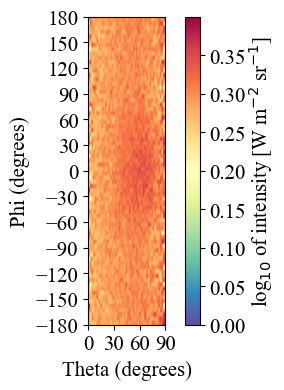

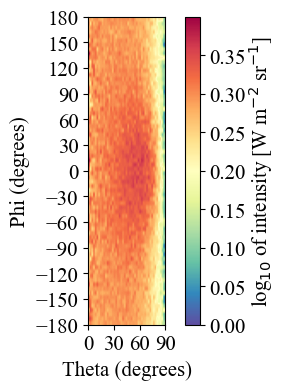

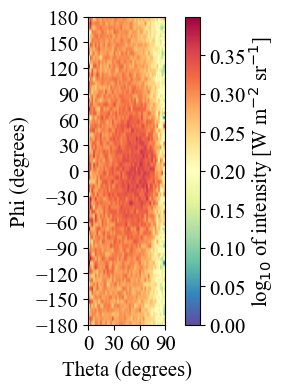

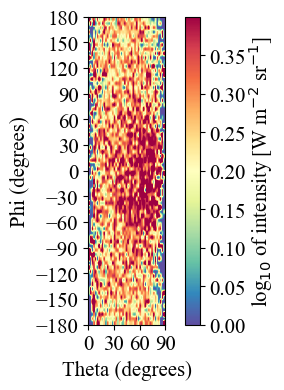

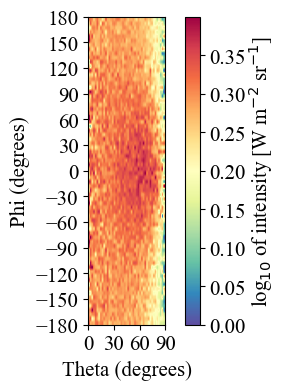

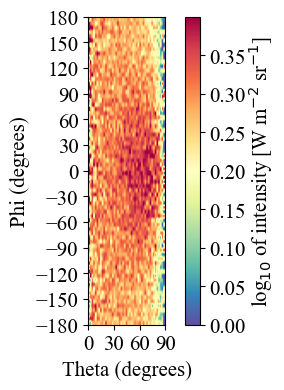

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

COD_v = np.array([10])
bandmode_v = ['channels']
d_th = 2
bins_theta = np.arange(0, 91, d_th)
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs = axs.ravel()
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
#channels = ['C02']
N_bundles = 10000
font = 10  # Define base font size
Ang_D = []
for ang in [0,15,30,45,60]:
    for ch_idx, channel in enumerate(channels):
        for iCOD in COD_v:
            # fdir = "/mnt/dengnan/RTM_10000/"
            fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
            filename = '/' + f'uwxyzr_COD={iCOD}_th0={ang}_Ta=299_RH=61.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    Rc_rtm, R_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=0.4
                    ghi2d_show(R_c, channel, ang, vmax, logscale=True)
                    #H_theta = np.sum(H_c, axis=1)
                Ang_D.append(R_c)

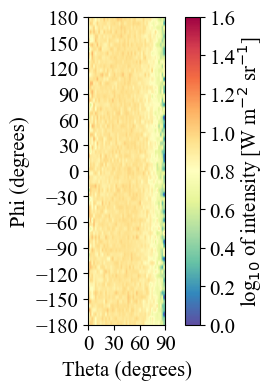

In [69]:
ghi2d_show(H_c,channel,ang, logscale=True)

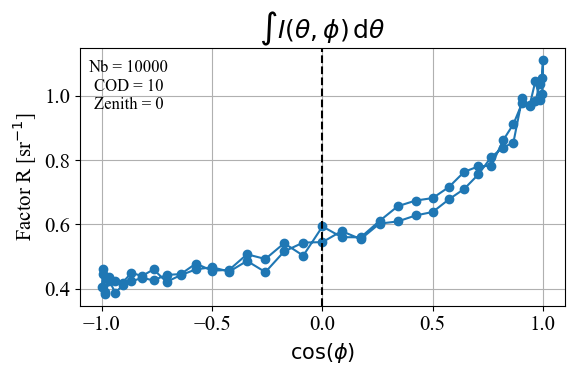

Mean intensity: 6.2351e-01
Standard deviation: 2.1008e-01
Relative std deviation: 33.69%


In [152]:
# H_c.shape = (45,72)
# bins_theta[:-1].shape = 45

d_phi = 5
d_theta = 2
bins_phi = np.arange(-180, 181, d_phi)

# Integrate intensity over theta axis → get 1D function of phi
H_phi = np.sum(H_c.T, axis=1) * np.deg2rad(d_theta)  # assumes d_theta = 2 degrees
AngD = [] 
#Ang = np.array([0, 15, 30, 45])
AngD.append(H_phi)
# Plotting
cos = True  # set to True if you want cos(phi) instead of phi
font = 12

plt.figure(figsize=(6, 4))
ax = plt.gca()  # get current axis

if cos:
    x = np.cos(np.deg2rad(bins_phi[:-1]))
    ax.plot(x, H_phi, 'o-')
    ax.set_xlabel(r'$\cos(\phi)$')
else:
    ax.plot(bins_phi[:-1], H_phi, 'o-')
    ax.set_xlabel(r'$\phi$ [degrees]')
    ax.set_xticks(np.arange(-180, 181, 60))

ax.set_title(r'$\int I(\theta, \phi)\,\mathrm{d}\theta$')
#ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
ax.set_ylabel(r'Factor R [sr$^{-1}$]')
#ax.set_ylim(20, 30)
ax.axvline(0, color='black', linestyle='--')
ax.text(0.1, 0.85, f'Nb = {10000}\nCOD = 10\nZenith = 0', fontsize=font, ha='center', va='center', transform=ax.transAxes)
ax.grid(True)
plt.tight_layout()
plt.show()

# Stats to assess isotropy
mean_H = np.mean(H_phi)
std_H = np.std(H_phi)
rel_std = std_H / mean_H

print(f'Mean intensity: {mean_H:.4e}')
print(f'Standard deviation: {std_H:.4e}')
print(f'Relative std deviation: {rel_std:.2%}')

# 2. Sensitive test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

COD_v = np.array([10])
bandmode_v = ['channels']
d_th = 2
bins_theta = np.arange(0, 91, d_th)
T_a = 294
#rh0_v = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])/100
rh0_v = np.array([10, 30, 60, 90])#/100

channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
#channels = ['C02']
N_bundles = 10000
font = 10  # Define base font size
Ang_D = []
#for ang in [0,15,30,45,60]:
for rh in rh0_v:
    for ch_idx, channel in enumerate(channels):
        for iCOD in COD_v:
             fdir = "/mnt/dengnan/RTM_10000/"
            #fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
            filename = '/' + f'uwxyzr_COD={iCOD}_th0=45_Ta=294_RH={rh}.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    Rc_rtm, R_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=0.4
                    ghi2d_show(R_c, channel, ang, vmax, logscale=True)
                    #H_theta = np.sum(H_c, axis=1)
                Ang_D.append(R_c)

### COD sensitive test

In [8]:
COD_v = np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
COD_v

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 25., 30.,
       35., 40., 45., 50.])

In [2]:
import matplotlib.colors as mcolors
def ghi2d_show(F_ghi_2d, channel, COD, vmax):
    font = 15
    fontfml = 'Times New Roman'
    plt.rcParams['font.size'] = font
    plt.rcParams['font.family'] = fontfml
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.arange(-180, 181, d_phi)
    
    norm = mcolors.Normalize(vmin=0, vmax=vmax)

    # Create a new figure with defined size
    fig = plt.figure(figsize=(5, 4))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=-0.1, hspace=0.0)

    # Apply logarithmic scaling if needed
    
    Z = F_ghi_2d.T

    # Create the subplot
    ax1 = fig.add_subplot(gs1[0, 0])

    # The extent parameter defines the bounding box in data coordinates
    extent = [bins_theta[0], bins_theta[-1], bins_phi[0], bins_phi[-1]]

    # Display the image with the appropriate bin edges
    im = ax1.imshow(Z, cmap='Spectral_r', origin="lower", norm=norm,extent=extent)

    # Set x and y labels
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Phi (degrees)')

    # Set ticks for x-axis based on the bins
    ax1.set_xticks(np.arange(0, 90 + 30, 30))  # Set ticks at each bin edge
    ax1.set_yticks(np.arange(-180, 180 + 30, 30))  # Set ticks at each bin edge

    # Add a color bar
    cbar1 = plt.colorbar(im)
    # Add a color bar with custom ticks
    cbar1.set_ticks(np.arange(0, vmax, 0.2))  # Set ticks from 0 to 2 with a step of 0.5
    cbar1.set_label('Nor. R', rotation=90,
                    labelpad=0, fontsize=font, family=fontfml)  # ****

    cbar1.ax.tick_params(labelsize=font, labelcolor='black')  # ****
    # Show the plot
    fig_dir = "./figures/AngularDisFuc/"
    plt.savefig(fig_dir+f'Intensity_{channel}_COD={COD}_Ta=294_rh=60_C02_th0=30.png', dpi=300, bbox_inches='tight')
    plt.show()
    return None

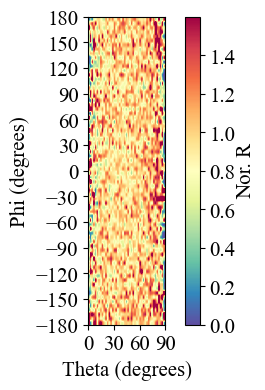

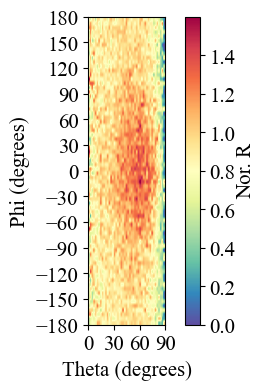

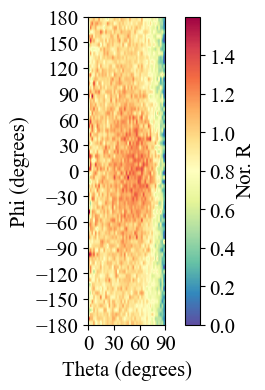

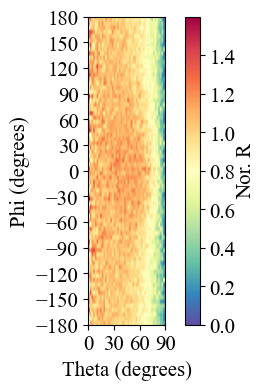

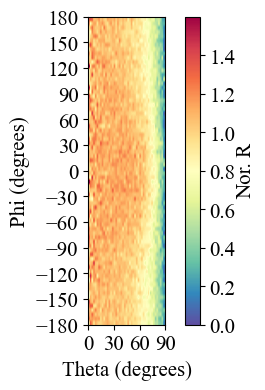

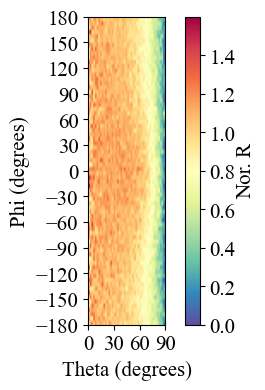

In [24]:
from fun_nearealtime_RTM import nearealtime_RTM
#from AngDistLUT import saveLUT 
channels=['C02']# 'C02', 'C03', 'C04', 'C05', 'C06']
COD_v = np.array([0,6,10,20,30,40])
#np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
Sun_Zen_v = np.array([30]) # 0,15,30,45,60
T_a = 294
bandmode_v = ['channels']
rh0_v = np.array([60])#/100
N_bundles = 10000
Ang_D = []
for iCOD in COD_v:
    iCOD = int(iCOD)
    
    for ang in Sun_Zen_v:
        for ch_idx, channel in enumerate(channels):
            fdir = "/mnt/dengnan/RTM_10000/"
            #fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
            filename = '/' + f'uwxyzr_COD={iCOD}_th0={ang}_Ta=294_RH=30.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    Rc_rtm, R_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=1.6
                    ghi2d_show(R_c, channel, iCOD, vmax)
                    # H_theta = np.sum(H_c, axis=1)
                    Ang_D.append(R_c)

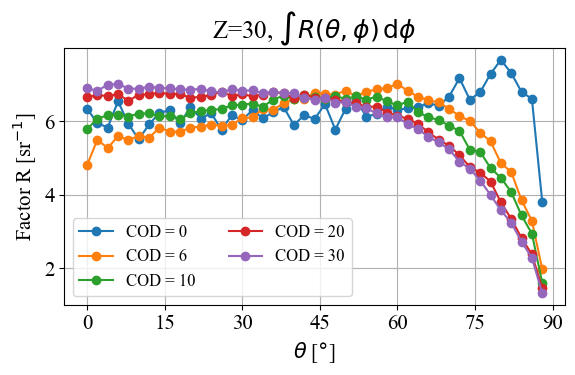

In [27]:
d_phi = 5
d_theta = 2
bins_theta = np.arange(0, 91, d_theta)

# Integrate intensity over theta axis → get 1D function of phi

# Plotting
cos = False# set to True if you want cos(phi) instead of phi
font = 12
COD_v = np.array([0,6,10,20,30,40])
n_channels = 1
channels=['C02']

for c_idx, channel in enumerate(channels):
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    for i in range(5):
        # Extract values for this channel across all angles
        H_c =Ang_D[i * n_channels + c_idx]
        H_phi = np.sum(H_c, axis=1) * np.deg2rad(d_phi) #/ F_dw_os_srf[c_idx]  # assumes d_theta = 2 degrees
        if cos:
            x = np.cos(np.deg2rad(bins_theta[:-1]))
            ax.plot(x, H_phi, 'o-',label = f'Z = {Ang[i]}')
            ax.set_xlabel(r'$\cos(\theta)$')
        else:
            ax.plot(bins_theta[:-1], H_phi, 'o-',label = f'COD = {COD_v[i]}')
            ax.set_xlabel(r'$\theta$ [$\degree$]')
            ax.set_xticks(np.arange(0, 90+15, 15))

    ax.set_title(r'Z=30, $\int R(\theta, \phi)\,\mathrm{d}\phi$')
    #ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
    ax.set_ylabel(r'Factor R [sr$^{-1}$]')
    #ax.set_ylim(0, 140)
    #ax.axvline(0, color='black', linestyle='--')
    #ax.text(0.1, 0.9, f'Nb = {10000}\nCOD = 10', fontsize=font, ha='center', va='center', transform=ax.transAxes)
    ax.grid(True)
    ax.legend(loc='best', ncol=2, fontsize=font)
    plt.tight_layout()
    fig_dir = "./figures/angular_distribution_unstable_test/"
    #plt.savefig(fig_dir+f'R_Intg_alongphi_{channel}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [48]:
import matplotlib.colors as mcolors
def ghi2d_show(F_ghi_2d, channel, rh, vmax):
    font = 15
    fontfml = 'Times New Roman'
    plt.rcParams['font.size'] = font
    plt.rcParams['font.family'] = fontfml
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.arange(-180, 181, d_phi)
    
    norm = mcolors.Normalize(vmin=0, vmax=vmax)

    # Create a new figure with defined size
    fig = plt.figure(figsize=(5, 4))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=-0.1, hspace=0.0)

    # Apply logarithmic scaling if needed
    
    Z = F_ghi_2d.T

    # Create the subplot
    ax1 = fig.add_subplot(gs1[0, 0])

    # The extent parameter defines the bounding box in data coordinates
    extent = [bins_theta[0], bins_theta[-1], bins_phi[0], bins_phi[-1]]

    # Display the image with the appropriate bin edges
    im = ax1.imshow(Z, cmap='Spectral_r', origin="lower", norm=norm,extent=extent)

    # Set x and y labels
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Phi (degrees)')

    # Set ticks for x-axis based on the bins
    ax1.set_xticks(np.arange(0, 90 + 30, 30))  # Set ticks at each bin edge
    ax1.set_yticks(np.arange(-180, 180 + 30, 30))  # Set ticks at each bin edge

    # Add a color bar
    cbar1 = plt.colorbar(im)
    # Add a color bar with custom ticks
    cbar1.set_ticks(np.arange(0, vmax, 0.2))  # Set ticks from 0 to 2 with a step of 0.5
    cbar1.set_label('Nor. R', rotation=90,
                    labelpad=0, fontsize=font, family=fontfml)  # ****

    cbar1.ax.tick_params(labelsize=font, labelcolor='black')  # ****
    # Show the plot
    fig_dir = "./figures/AngularDisFuc/"
    #plt.savefig(fig_dir+f'Intensity_{channel}_COD=10_Ta=294_rh={rh}_th0=30.png', dpi=300, bbox_inches='tight')
    plt.show()
    return None

### rh sensitive analysis

In [48]:
import matplotlib.colors as mcolors
def ghi2d_show(F_ghi_2d, channel, rh, vmax):
    font = 15
    fontfml = 'Times New Roman'
    plt.rcParams['font.size'] = font
    plt.rcParams['font.family'] = fontfml
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.arange(-180, 181, d_phi)
    
    norm = mcolors.Normalize(vmin=0, vmax=vmax)

    # Create a new figure with defined size
    fig = plt.figure(figsize=(5, 4))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=-0.1, hspace=0.0)

    # Apply logarithmic scaling if needed
    
    Z = F_ghi_2d.T

    # Create the subplot
    ax1 = fig.add_subplot(gs1[0, 0])

    # The extent parameter defines the bounding box in data coordinates
    extent = [bins_theta[0], bins_theta[-1], bins_phi[0], bins_phi[-1]]

    # Display the image with the appropriate bin edges
    im = ax1.imshow(Z, cmap='Spectral_r', origin="lower", norm=norm,extent=extent)

    # Set x and y labels
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Phi (degrees)')

    # Set ticks for x-axis based on the bins
    ax1.set_xticks(np.arange(0, 90 + 30, 30))  # Set ticks at each bin edge
    ax1.set_yticks(np.arange(-180, 180 + 30, 30))  # Set ticks at each bin edge

    # Add a color bar
    cbar1 = plt.colorbar(im)
    # Add a color bar with custom ticks
    cbar1.set_ticks(np.arange(0, vmax, 0.2))  # Set ticks from 0 to 2 with a step of 0.5
    cbar1.set_label('Nor. R', rotation=90,
                    labelpad=0, fontsize=font, family=fontfml)  # ****

    cbar1.ax.tick_params(labelsize=font, labelcolor='black')  # ****
    # Show the plot
    fig_dir = "./figures/AngularDisFuc/"
    #plt.savefig(fig_dir+f'Intensity_{channel}_COD=10_Ta=294_rh={rh}_th0=30.png', dpi=300, bbox_inches='tight')
    plt.show()
    return None

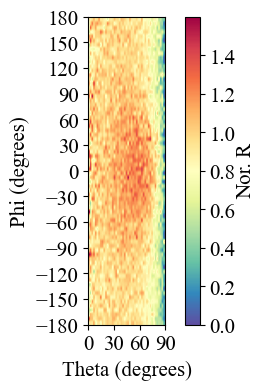

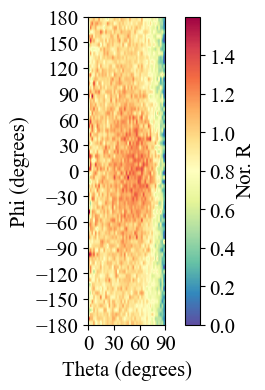

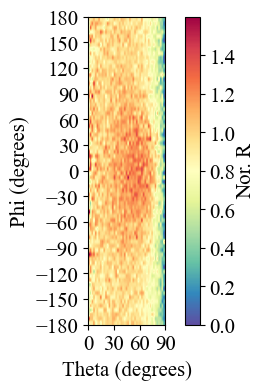

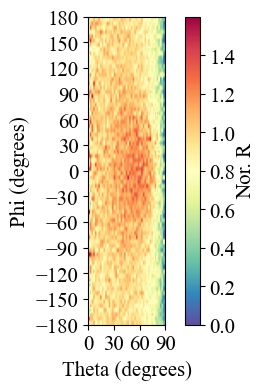

In [42]:
from fun_nearealtime_RTM import nearealtime_RTM
#from AngDistLUT import saveLUT 
channels=['C02']#, 'C02', 'C03', 'C04', 'C05', 'C06']
COD_v = np.array([10])
#np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
Sun_Zen_v = np.array([30]) # 0,15,30,45,60
T_a = 294
bandmode_v = ['channels']
rh0_v = np.array([30])#/100
N_bundles = 10000
Ang_D = []
for rh in rh0_v:
    iCOD = int(iCOD)
    for ang in Sun_Zen_v:
        for ch_idx, channel in enumerate(channels):
            fdir = "/mnt/dengnan/RTM_10000/"
            #fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
            filename = '/' + f'uwxyzr_COD=10_th0={ang}_Ta=294_RH={rh}.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    Rc_rtm, R_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=1.6
                    ghi2d_show(R_c, channel, rh, vmax)
                    # H_theta = np.sum(H_c, axis=1)
                Ang_D.append(R_c)

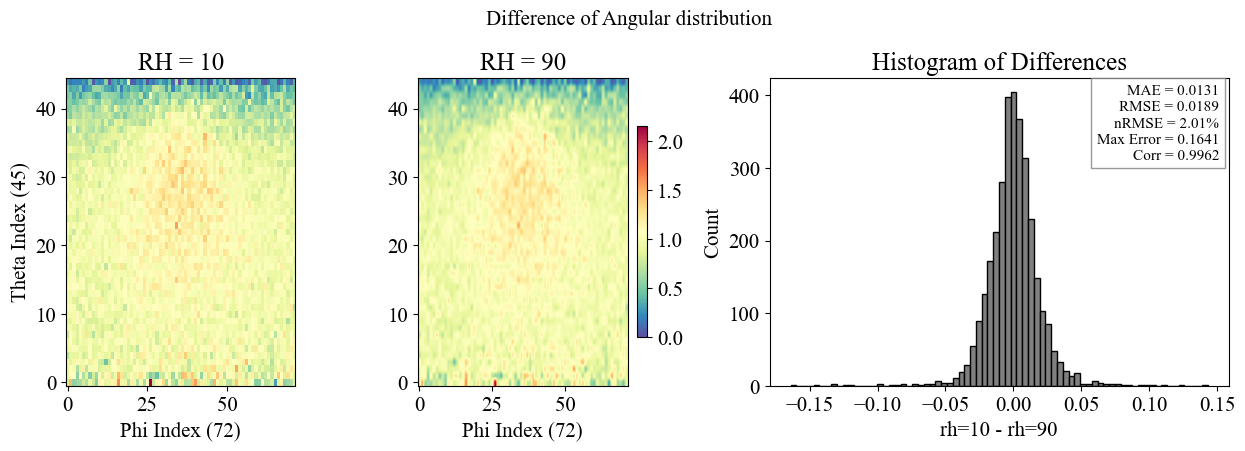

In [47]:
show_diff(Ang_D[0], Ang_D[-1])

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_diff(H_c, result):
    # --- Your metrics calculations ---
    mae = np.mean(np.abs(result - H_c))
    rmse = np.sqrt(np.mean((result - H_c)**2))
    nrmse = rmse / np.mean(H_c) *100
    max_err = np.max(np.abs(result - H_c))
    corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

    # --- Shared color limits for imshow ---
    vmin = min(H_c.min(), result.min())
    vmax = max(H_c.max(), result.max())

    # --- Create figure with 3 subplots using GridSpec ---
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])
    gs.update(wspace=0.4, hspace=0.15)

    # --- Plot 1: Original H_c ---
    ax0 = fig.add_subplot(gs[0])
    im0 = ax0.imshow(H_c, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax0.set_title('RH = 10')
    ax0.set_xlabel('Phi Index (72)')
    ax0.set_ylabel('Theta Index (45)')
    #plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

    # --- Plot 2: Smoothed result ---
    ax1 = fig.add_subplot(gs[1])
    im1 = ax1.imshow(result, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax1.set_title('RH = 90')
    ax1.set_xlabel('Phi Index (72)')
    ax1.set_ylabel('')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # --- Plot 3: Histogram of Differences ---
    ax2 = fig.add_subplot(gs[2])
    diff = (result - H_c).flatten()
    ax2.hist(diff, bins=72, color='gray', edgecolor='black')
    ax2.set_title("Histogram of Differences")
    ax2.set_xlabel("rh=10 - rh=90")
    ax2.set_ylabel("Count")

    # --- Add metrics as text box on the histogram ---
    metrics_text = (
        f"MAE = {mae:.4f}\n"
        f"RMSE = {rmse:.4f}\n"
        f"nRMSE = {nrmse:.2f}%\n"
        f"Max Error = {max_err:.4f}\n"
        f"Corr = {corr:.4f}"
    )
    # Place text in the upper right of the histogram axes
    ax2.text(0.98, 0.98, metrics_text, transform=ax2.transAxes,
            fontsize=11, va='top', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    fig_dir = 'figures/'
    fig.savefig(fig_dir+'RH_impact_AngDis.png', dpi=300, bbox_inches='tight')
    plt.suptitle("Difference of Angular distribution", fontsize=15, y=1.05)
    plt.tight_layout()
    plt.show()


### Run cases

### Ta sensitive test

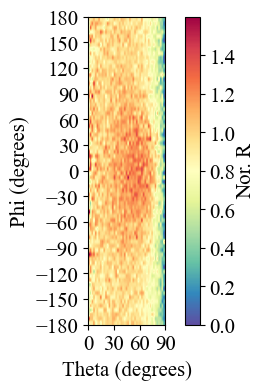

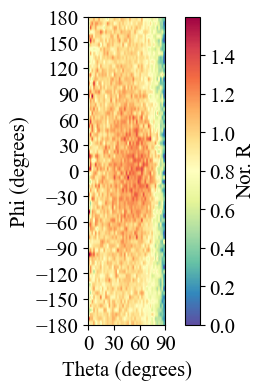

In [9]:
from fun_nearealtime_RTM import nearealtime_RTM
#from AngDistLUT import saveLUT 
channels=['C02']#, 'C02', 'C03', 'C04', 'C05', 'C06']
COD_v = np.array([10])
#np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
Sun_Zen_v = np.array([30]) # 0,15,30,45,60
T_a = 294
bandmode_v = ['channels']
rh0_v = np.array([60])#/100
N_bundles = 10000
Ang_D = []
for Ta in [294,304]:
    iCOD = int(iCOD)
    for ang in Sun_Zen_v:
        for ch_idx, channel in enumerate(channels):
            fdir = "/mnt/dengnan/RTM_10000/"
            #fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
            filename = '/' + f'uwxyzr_COD=10_th0={ang}_Ta={Ta}_RH=60.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    Rc_rtm, R_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=1.6
                    ghi2d_show(R_c, channel, Ta, vmax)
                    # H_theta = np.sum(H_c, axis=1)
                Ang_D.append(R_c)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_diff(H_c, result):
    # --- Your metrics calculations ---
    mae = np.mean(np.abs(result - H_c))
    rmse = np.sqrt(np.mean((result - H_c)**2))
    nrmse = rmse / np.mean(H_c) *100
    max_err = np.max(np.abs(result - H_c))
    corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

    # --- Shared color limits for imshow ---
    vmin = min(H_c.min(), result.min())
    vmax = max(H_c.max(), result.max())

    # --- Create figure with 3 subplots using GridSpec ---
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])
    gs.update(wspace=0.4, hspace=0.15)

    # --- Plot 1: Original H_c ---
    ax0 = fig.add_subplot(gs[0])
    im0 = ax0.imshow(H_c, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax0.set_title('Ta = 294')
    ax0.set_xlabel('Phi Index (72)')
    ax0.set_ylabel('Theta Index (45)')
    #plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

    # --- Plot 2: Smoothed result ---
    ax1 = fig.add_subplot(gs[1])
    im1 = ax1.imshow(result, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax1.set_title('Ta = 304')
    ax1.set_xlabel('Phi Index (72)')
    ax1.set_ylabel('')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # --- Plot 3: Histogram of Differences ---
    ax2 = fig.add_subplot(gs[2])
    diff = (result - H_c).flatten()
    ax2.hist(diff, bins=72, color='gray', edgecolor='black')
    ax2.set_title("Histogram of Differences")
    ax2.set_xlabel("Ta=294 - Ta=304")
    ax2.set_ylabel("Count")

    # --- Add metrics as text box on the histogram ---
    metrics_text = (
        f"MAE = {mae:.4f}\n"
        f"RMSE = {rmse:.4f}\n"
        f"nRMSE = {nrmse:.2f}%\n"
        f"Max Error = {max_err:.4f}\n"
        f"Corr = {corr:.4f}"
    )
    # Place text in the upper right of the histogram axes
    ax2.text(0.98, 0.98, metrics_text, transform=ax2.transAxes,
            fontsize=11, va='top', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    fig_dir = 'figures/'
    fig.savefig(fig_dir+'Ta_impact_AngDis.png', dpi=300, bbox_inches='tight')
    plt.suptitle("Difference of Angular distribution", fontsize=15, y=1.05)
    plt.tight_layout()
    plt.show()


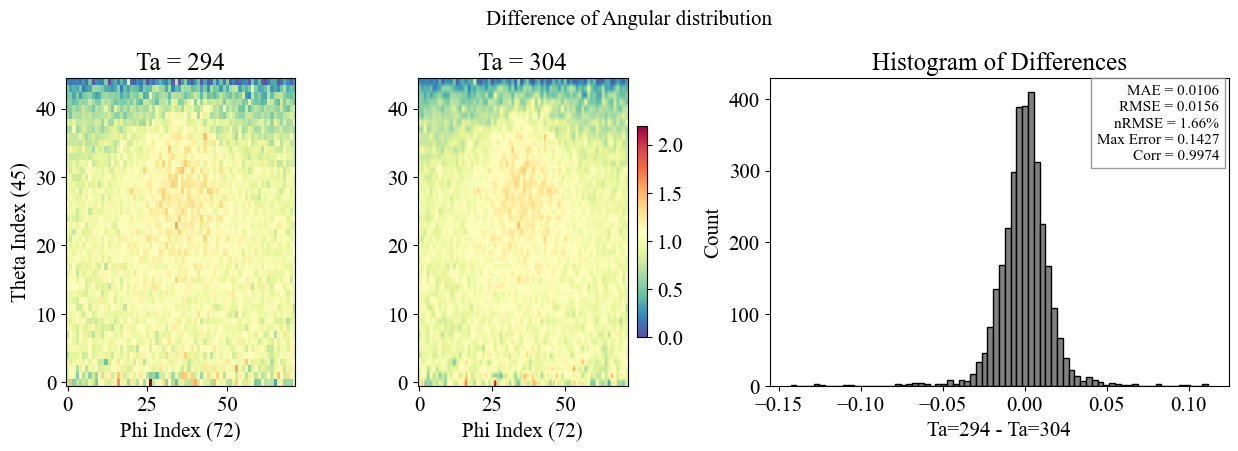

In [16]:
show_diff(Ang_D[0],Ang_D[-1])

## theta and phi trends

In [9]:
print(len(Ang_D))
Ang_D[0].shape

30


(45, 72)

In [154]:
F_dw_os_srf = np.load('./GOES_data/'+'F_dw_os_srf.npy')
F_dw_os_srf

array([ 74.87922869, 134.24362686,  33.70391083,   4.92360761,
        11.08340386,   3.52294571])

# 3.Theta trends

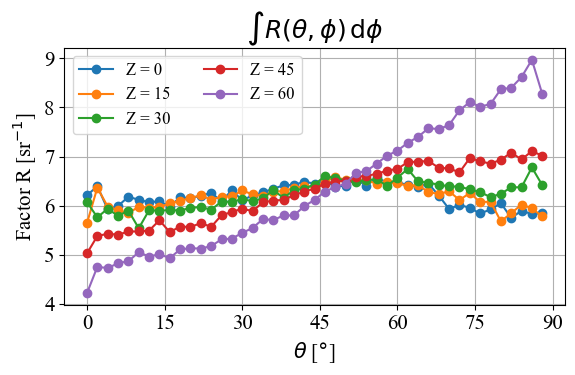

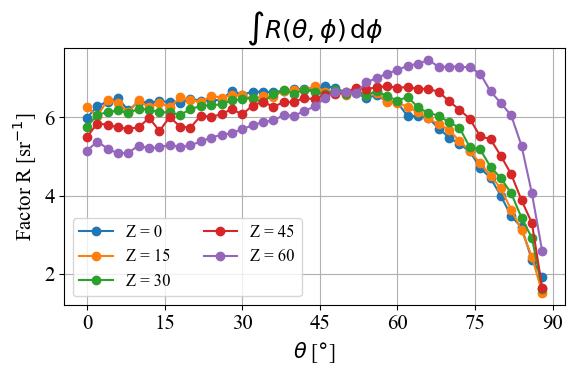

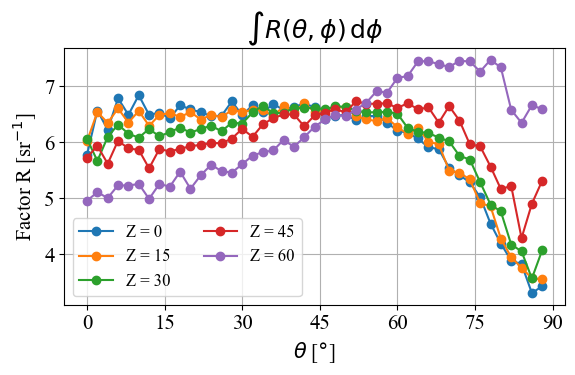

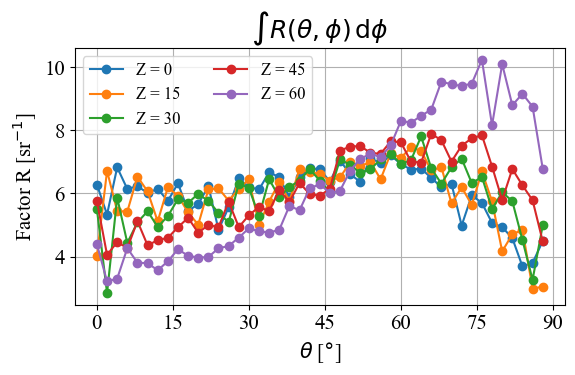

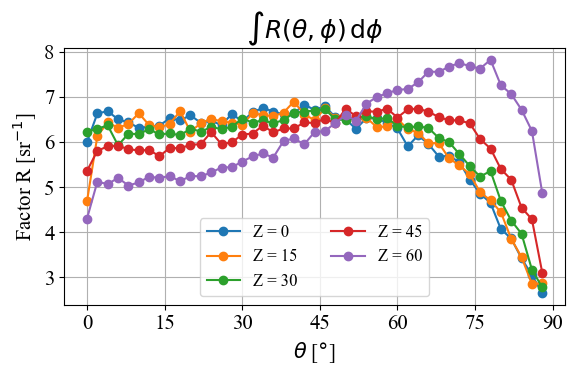

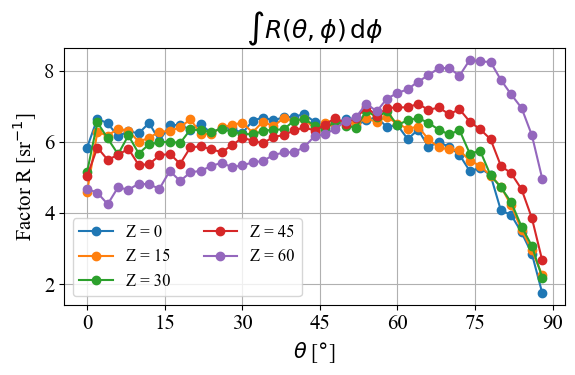

In [10]:
d_phi = 5
d_theta = 2
bins_theta = np.arange(0, 91, d_theta)

# Integrate intensity over theta axis → get 1D function of phi

# Plotting
cos = False# set to True if you want cos(phi) instead of phi
font = 12
Ang = np.array([0, 15, 30, 45, 60])
n_channels = 6

for c_idx, channel in enumerate(channels):
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    for i in range(5):
        # Extract values for this channel across all angles
        H_c =Ang_D[i * n_channels + c_idx]
        H_phi = np.sum(H_c, axis=1) * np.deg2rad(d_phi) #/ F_dw_os_srf[c_idx]  # assumes d_theta = 2 degrees
        if cos:
            x = np.cos(np.deg2rad(bins_theta[:-1]))
            ax.plot(x, H_phi, 'o-',label = f'Z = {Ang[i]}')
            ax.set_xlabel(r'$\cos(\theta)$')
        else:
            ax.plot(bins_theta[:-1], H_phi, 'o-',label = f'Z = {Ang[i]}')
            ax.set_xlabel(r'$\theta$ [$\degree$]')
            ax.set_xticks(np.arange(0, 90+15, 15))

    ax.set_title(r'$\int R(\theta, \phi)\,\mathrm{d}\phi$')
    #ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
    ax.set_ylabel(r'Factor R [sr$^{-1}$]')
    #ax.set_ylim(0, 140)
    #ax.axvline(0, color='black', linestyle='--')
    #ax.text(0.1, 0.9, f'Nb = {10000}\nCOD = 10', fontsize=font, ha='center', va='center', transform=ax.transAxes)
    ax.grid(True)
    ax.legend(loc='best', ncol=2, fontsize=font)
    plt.tight_layout()
    fig_dir = "./figures/angular_distribution_unstable_test/"
    plt.savefig(fig_dir+f'R_Intg_alongphi_{channel}.png', dpi=300, bbox_inches='tight')
    plt.show()

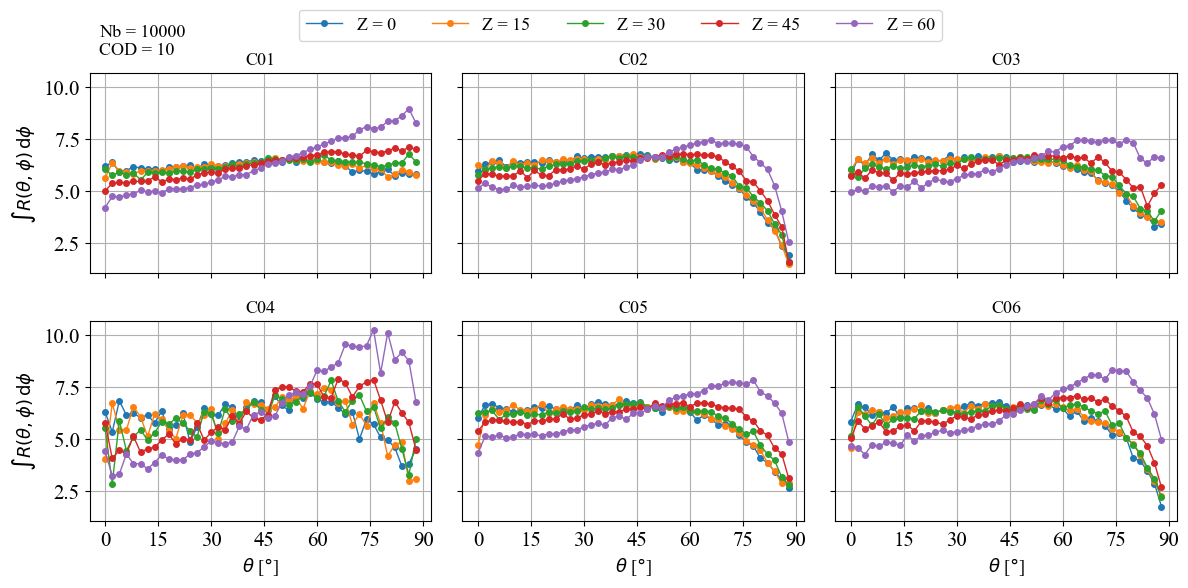

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
Ang = np.array([0, 15, 30, 45, 60])
n_channels = 6
n_angles = len(Ang)

d_phi = 5
d_theta = 2
bins_theta = np.arange(0, 91, d_theta)
cos = False
font = 13
Nb = 10000
COD = 10

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.flatten()

lines = []
labels = []

for c_idx, channel in enumerate(channels):
    ax = axs[c_idx]

    for i in range(n_angles):
        H_c = Ang_D[i * n_channels + c_idx]
        H_phi = np.sum(H_c, axis=1) * np.deg2rad(d_phi) # / F_dw_os_srf[c_idx]

        if cos:
            x = np.cos(np.deg2rad(bins_theta[:-1]))
            l, = ax.plot(x, H_phi, 'o-', label=f'Z = {Ang[i]}',linewidth=1,markersize=4)
        else:
            l, = ax.plot(bins_theta[:-1], H_phi, 'o-', label=f'Z = {Ang[i]}',linewidth=1,markersize=4)
            ax.set_xticks(np.arange(0, 91, 15))

        if c_idx == 0:
            lines.append(l)
            labels.append(f'Z = {Ang[i]}')

    ax.set_title(channel, fontsize=font)

    # Only show y-labels for axs[0] and axs[3]
    if c_idx in [0, 3]:
        ax.set_ylabel(r'$\int R(\theta, \phi)\,\mathrm{d}\phi$', fontsize=font)
        
    else:
        ax.set_ylabel('')

    # Only show x-labels for the bottom row (axs[3], [4], [5])
    if c_idx in [3, 4, 5]:
        if cos:
            ax.set_xlabel(r'$\cos(\theta)$', fontsize=font)
        else:
            ax.set_xlabel(r'$\theta$ [$\degree$]', fontsize=font)
    else:
        ax.set_xlabel('')

    ax.grid(True)

# Remove any unused axes
for i in range(len(channels), len(axs)):
    fig.delaxes(axs[i])

# Global title
#fig.suptitle(r'$\int R(\theta, \phi)\,\mathrm{d}\phi$', fontsize=16)

# Upper-left global text
fig.text(0.08, 0.96, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
         ha='left', va='top', transform=fig.transFigure)

# Legend in upper-right of whole figure
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.79,1))

plt.tight_layout(rect=[0, 0, 1,0.95])
plt.savefig('./figures/angular_distribution_unstable_test/R_Intg_alongphi_allchannels.png',
            dpi=300, bbox_inches='tight')
plt.show()

### phi trends

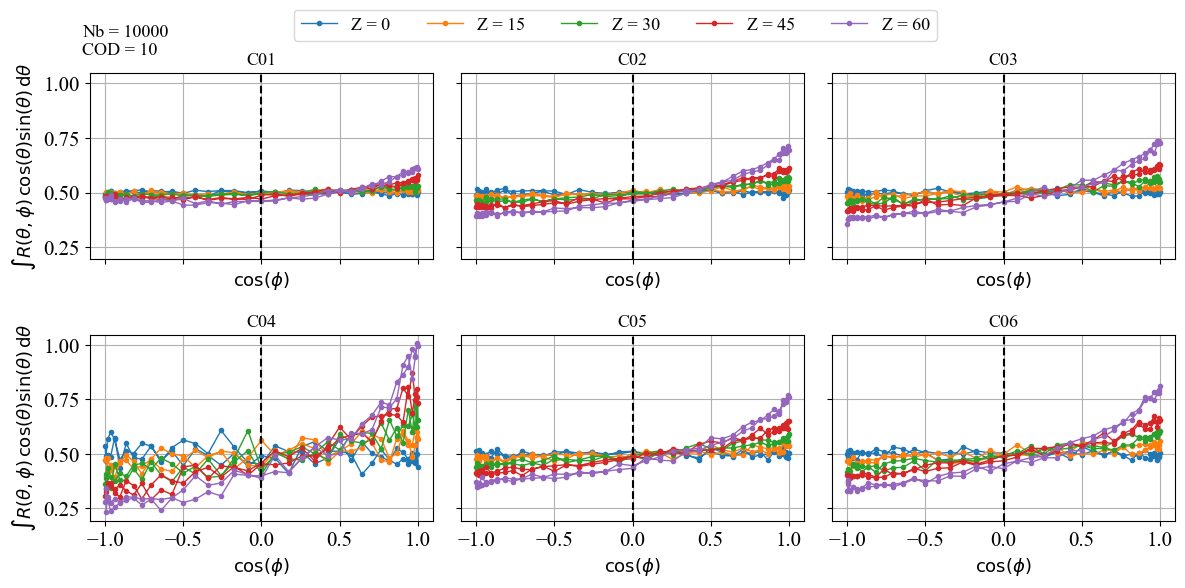

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
cos = True
font = 13
d_phi = 5
d_theta = 2
Nb = 10000
COD = 10

Ang = np.array([0, 15, 30, 45, 60])
n_angles = len(Ang)
n_channels = 6
bins_phi = np.arange(-180, 181, d_phi)

# Set up subplots for 6 channels
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.flatten()

lines = []
labels = []

for c_idx, channel in enumerate(channels):
    ax = axs[c_idx]

    for i in range(n_angles):
        # Each H_c is (phi_bins, theta_bins)
        H_c = Ang_D[i * n_channels + c_idx]
        H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0)
        H_theta_intg = H.T * np.deg2rad(d_theta)# / F_dw_os_srf[c_idx]  # integrate over theta

        if cos:
            x = np.cos(np.deg2rad(bins_phi[:-1]))
            l, = ax.plot(x, H_theta_intg, 'o-', label=f'Z = {Ang[i]}', linewidth=1, markersize=3)
            ax.set_xlabel(r'$\cos(\phi)$', fontsize=font)
        else:
            l, = ax.plot(bins_phi[:-1], H_theta_intg, 'o-', label=f'Z = {Ang[i]}', linewidth=1, markersize=4)
            ax.set_xticks(np.arange(-180, 181, 60))

        if c_idx == 0:
            lines.append(l)
            labels.append(f'Z = {Ang[i]}')

    ax.set_title(channel, fontsize=font)

    # Only show y-labels for axs[0] and axs[3]
    if c_idx in [0, 3]:
        ax.set_ylabel(r'$\int R(\theta, \phi)\,\cos(\theta)\sin(\theta)\,\mathrm{d}\theta$', fontsize=font)

    # Only show x-labels for bottom row
    if c_idx in [3, 4, 5]:
        if cos:
            ax.set_xlabel(r'$\cos(\phi)$', fontsize=font)
        else:
            ax.set_xlabel(r'$\phi$ [$\degree$]', fontsize=font)

    ax.axvline(0, color='black', linestyle='--')
    ax.grid(True)

# Remove unused axes (if any)
for i in range(len(channels), len(axs)):
    fig.delaxes(axs[i])

# Global title
#fig.suptitle(r'$\int R(\theta, \phi)\,\cos(\theta)\sin(\theta)\,\mathrm{d}\theta$', fontsize=16)

# Global upper-left text
fig.text(0.07, 0.96, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
         ha='left', va='top', transform=fig.transFigure)

# Shared legend in upper-right of whole figure
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.79,1))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./figures/angular_distribution_unstable_test/R_Intg_alongtheta_allchannels_cosths.png',
           dpi=300, bbox_inches='tight')
plt.show()

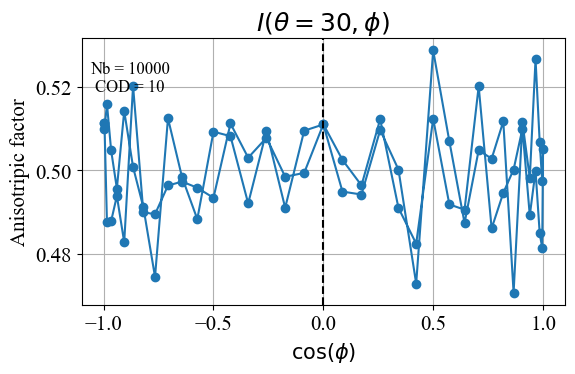

In [59]:
cos = True  # set to True if you want cos(phi) instead of phi
font = 12
bins_phi = np.arange(-180, 181, d_phi)
plt.figure(figsize=(6, 4))
ax = plt.gca()  # get current axis
Ang = np.array([0, 15, 30, 45, 60])
for i in range (4,5):
    H_c = Ang_D[i]
    H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0)
    H_theta_intg = H.T * np.deg2rad(d_theta)
    if cos:
        x = np.cos(np.deg2rad(bins_phi[:-1]))
        ax.plot(x, H_theta_intg, 'o-',label = f'Z = {Ang[i]}')
        ax.set_xlabel(r'$\cos(\phi)$')
    else:
        ax.plot(bins_phi[:-1], H_theta_intg, 'o-',label = f'Z = {Ang[i]}')
        ax.set_xlabel(r'$\phi$ [degrees]')
        ax.set_xticks(np.arange(-180, 181, 60))

ax.set_title(r'$I(\theta=30, \phi)$')
ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
ax.set_ylabel(r'Anisotripic factor')
#ax.set_ylim(20, 40)
ax.axvline(0, color='black', linestyle='--')
ax.text(0.1, 0.85, f'Nb = {10000}\nCOD = 10',
         fontsize=font, ha='center', va='center', transform=ax.transAxes)
ax.grid(True)
#ax.legend(loc='upper right', fontsize=font)
plt.tight_layout()
plt.show()

# Stats to assess isotropy
mean_H = np.mean(H_phi)
std_H = np.std(H_phi)
rel_std = std_H / mean_H

## LUT independent test

$\int_0^{\pi/2} \int_0^{2\pi} R(\theta, \phi) \,\cos\theta \sin\theta \, d\phi \, d\theta = 1$

$R(\phi) = \int R(\theta, \phi)\,\cos(\theta)\sin(\theta)\,\mathrm{d}\theta$

$R(\theta) = \int R(\theta, \phi) d\phi $

$ R(\theta, \phi) ==  R(\theta) R(\phi) $

In [11]:
len(Ang_D)

6

In [15]:
from scipy.ndimage import gaussian_filter1d
n_channels = 1
i = 3 # Ang=0,15,30,45,60
c_idx = 1 # channel2
H_c = Ang_D[c_idx]

# integrate over theta
H_phi_intg = np.sum(H_c, axis=1) * np.deg2rad(d_phi)

# method 1
# integrate over theta
# H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0) #
# H_theta_intg = H.T * np.deg2rad(d_theta) 
# Example with verification
# result = np.outer(H_theta_intg, H_phi_intg)
# print(result.shape)  # Should print: (72, 45)

# # Verify specific elements
# print(result[0,0] == H_theta_intg[0] * H_phi_intg[0])  # Should be True
# print(result[71,44] == H_theta_intg[71] * H_phi_intg[44])  # Should be True

# method 2
H_theta = H_c / H_phi_intg[:, np.newaxis]
# smooth
# H_phi_intg is a 1D NumPy array
H_phi_intg_s = gaussian_filter1d(H_phi_intg, sigma=1)
H_theta_s = gaussian_filter1d(H_theta, sigma=1, axis=1, mode='reflect')
result = H_phi_intg_s[:, np.newaxis] * H_theta_s

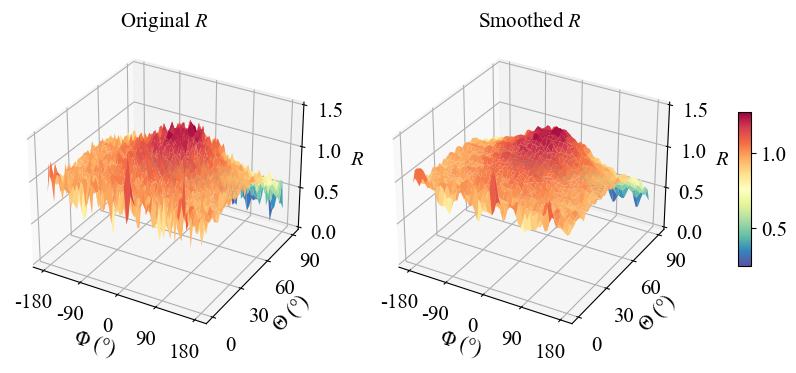

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

# --- Font setup ---
font = 15
fontfml = 'Times New Roman'
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = fontfml
plt.rcParams['mathtext.it'] = f'{fontfml}:italic'
plt.rcParams['mathtext.bf'] = f'{fontfml}:bold'

# --- Dummy data (replace with actual data) ---
# H_c = np.random.rand(45, 72)
# result = np.random.rand(45, 72)

# --- Metrics ---
mae = np.mean(np.abs(result - H_c))
rmse = np.sqrt(np.mean((result - H_c) ** 2))
corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

# --- Coordinates ---
n_theta, n_phi = H_c.shape
theta = np.linspace(0, 90, n_theta)
phi = np.linspace(-180, 180, n_phi)
PHI, THETA = np.meshgrid(phi, theta)

# --- Create figure and GridSpec ---
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2)  # Make subplot 3 thinner
gs.update(wspace=-0.3)  # Tight spacing between 1 and 2, bigger gap before 3

# --- Subplot 1: Original H_c ---
ax0 = fig.add_subplot(gs[0], projection='3d')
surf0 = ax0.plot_surface(PHI, THETA, H_c, cmap='Spectral_r', edgecolor='none', antialiased=True)
ax0.set_title('Original $R$', fontsize=font)
ax0.set_xlabel(r'$\Phi$ (°)', fontsize=font)
ax0.set_ylabel(r'$\Theta$ (°)', fontsize=font)
ax0.set_zlabel(r'$R$', fontsize=font)
ax0.view_init(elev=30, azim=-60)
ax0.set_zlim(0, 1.5)
ax0.set_xticks(np.arange(-180, 181, 90))
ax0.set_xticklabels([f'{d}' for d in np.arange(-180, 181, 90)])
ax0.set_yticks(np.arange(0, 91, 30))
ax0.set_yticklabels([f'{d}' for d in np.arange(0, 91, 30)])
#fig.colorbar(surf0, ax=ax0, shrink=0.5, aspect=20, pad=0.1)

# --- Subplot 2: Smoothed result ---
ax1 = fig.add_subplot(gs[1], projection='3d')
surf1 = ax1.plot_surface(PHI, THETA, result, cmap='Spectral_r', edgecolor='none', antialiased=True)
ax1.set_title('Smoothed $R$', fontsize=font)
ax1.set_xlabel(r'$\Phi$ (°)', fontsize=font)
ax1.set_ylabel(r'$\Theta$ (°)', fontsize=font)
ax1.set_zlabel(r'$R$', fontsize=font)
ax1.view_init(elev=30, azim=-60)
ax1.set_zlim(0, 1.5)
ax1.set_xticks(np.arange(-180, 181, 90))
ax1.set_xticklabels([f'{d}' for d in np.arange(-180, 181, 90)])
ax1.set_yticks(np.arange(0, 91, 30))
ax1.set_yticklabels([f'{d}' for d in np.arange(0, 91, 30)])
fig.colorbar(surf0, ax=ax1, shrink=0.5, aspect=12, pad=0.1)


# --- Title and layout ---
#plt.suptitle("Comparison of Original and Smoothed Angular Distribution $R$", fontsize=font + 1, y=1.05)
plt.tight_layout()
fig_dir = 'figures/'
#fig.savefig(fig_dir+'Smooth_R_3D.png', dpi=300, bbox_inches='tight')

plt.show()

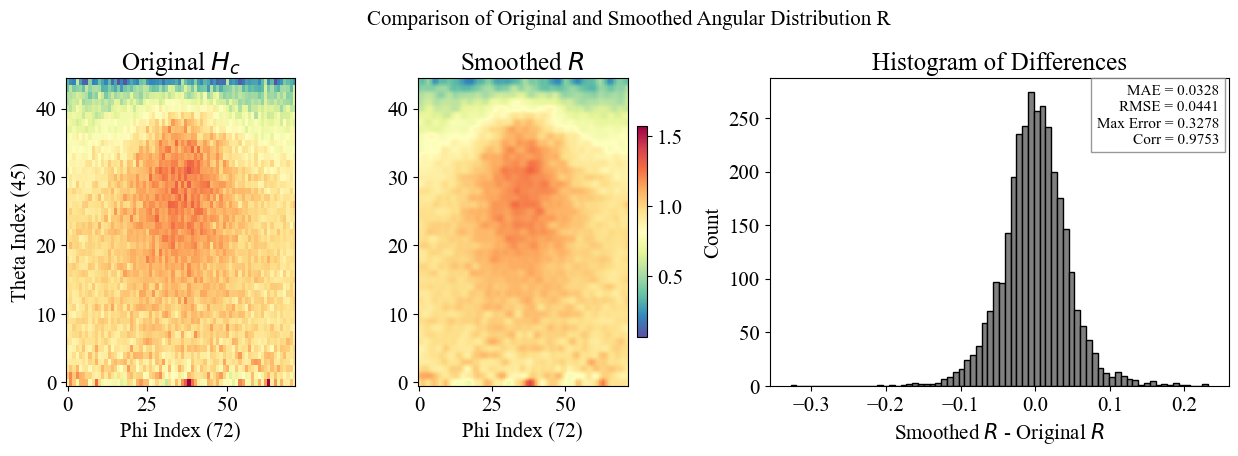

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# --- Your metrics calculations ---
mae = np.mean(np.abs(result - H_c))
rmse = np.sqrt(np.mean((result - H_c)**2))
max_err = np.max(np.abs(result - H_c))
corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

# --- Shared color limits for imshow ---
vmin = min(H_c.min(), result.min())
vmax = max(H_c.max(), result.max())

# --- Create figure with 3 subplots using GridSpec ---
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])
gs.update(wspace=0.4, hspace=0.15)

# --- Plot 1: Original H_c ---
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(H_c, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
ax0.set_title('Original $H_c$')
ax0.set_xlabel('Phi Index (72)')
ax0.set_ylabel('Theta Index (45)')
#plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

# --- Plot 2: Smoothed result ---
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(result, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
ax1.set_title('Smoothed $R$')
ax1.set_xlabel('Phi Index (72)')
ax1.set_ylabel('')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# --- Plot 3: Histogram of Differences ---
ax2 = fig.add_subplot(gs[2])
diff = (result - H_c).flatten()
ax2.hist(diff, bins=72, color='gray', edgecolor='black')
ax2.set_title("Histogram of Differences")
ax2.set_xlabel("Smoothed $R$ - Original $R$")
ax2.set_ylabel("Count")

# --- Add metrics as text box on the histogram ---
metrics_text = (
    f"MAE = {mae:.4f}\n"
    f"RMSE = {rmse:.4f}\n"
    f"Max Error = {max_err:.4f}\n"
    f"Corr = {corr:.4f}"
)
# Place text in the upper right of the histogram axes
ax2.text(0.98, 0.98, metrics_text, transform=ax2.transAxes,
         fontsize=11, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

fig_dir = 'figures/'
#fig.savefig(fig_dir+'Smooth_R_2D.png', dpi=300, bbox_inches='tight')
plt.suptitle("Comparison of Original and Smoothed Angular Distribution R", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()


## Method2 SUVT

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_diff(H_c, result):
    # --- Your metrics calculations ---
    mae = np.mean(np.abs(result - H_c))
    rmse = np.sqrt(np.mean((result - H_c)**2))
    nrmse = rmse / np.mean(H_c) *100
    max_err = np.max(np.abs(result - H_c))
    corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

    # --- Shared color limits for imshow ---
    vmin = min(H_c.min(), result.min())
    vmax = max(H_c.max(), result.max())

    # --- Create figure with 3 subplots using GridSpec ---
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])
    gs.update(wspace=0.4, hspace=0.15)

    # --- Plot 1: Original H_c ---
    ax0 = fig.add_subplot(gs[0])
    im0 = ax0.imshow(H_c, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax0.set_title('Original $H_c$')
    ax0.set_xlabel('Phi Index (72)')
    ax0.set_ylabel('Theta Index (45)')
    #plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

    # --- Plot 2: Smoothed result ---
    ax1 = fig.add_subplot(gs[1])
    im1 = ax1.imshow(result, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax1.set_title('Smoothed $R$')
    ax1.set_xlabel('Phi Index (72)')
    ax1.set_ylabel('')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # --- Plot 3: Histogram of Differences ---
    ax2 = fig.add_subplot(gs[2])
    diff = (result - H_c).flatten()
    ax2.hist(diff, bins=72, color='gray', edgecolor='black')
    ax2.set_title("Histogram of Differences")
    ax2.set_xlabel("Smoothed $R$ - Original $R$")
    ax2.set_ylabel("Count")

    # --- Add metrics as text box on the histogram ---
    metrics_text = (
        f"MAE = {mae:.4f}\n"
        f"RMSE = {rmse:.4f}\n"
        f"nRMSE = {nrmse:.2f}%\n"
        f"Max Error = {max_err:.4f}\n"
        f"Corr = {corr:.4f}"
    )
    # Place text in the upper right of the histogram axes
    ax2.text(0.98, 0.98, metrics_text, transform=ax2.transAxes,
            fontsize=11, va='top', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    fig_dir = 'figures/'
    #fig.savefig(fig_dir+'Smooth_R_2D.png', dpi=300, bbox_inches='tight')
    plt.suptitle("Comparison of Original and Smoothed Angular Distribution R", fontsize=15, y=1.05)
    plt.tight_layout()
    plt.show()


In [103]:
import numpy as np

def svd_rank_k_approx(matrix, rank=2):
    """
    Perform a rank-k approximation of a 2D matrix using SVD.

    Parameters:
        matrix (ndarray): Input 2D array (e.g. R(phi|theta))
        rank (int): Desired rank for approximation

    Returns:
        matrix_approx (ndarray): Rank-k approximated matrix
        U_k (ndarray): Left singular vectors (truncated)
        S_k (ndarray): Singular values (truncated)
        VT_k (ndarray): Right singular vectors (truncated)
    """
    U, S, VT = np.linalg.svd(matrix, full_matrices=False)
    U_k = U[:, :rank]
    S_k = np.diag(S[:rank])
    VT_k = VT[:rank, :]
    matrix_approx = U_k @ S_k @ VT_k
    return matrix_approx, U_k, S_k, VT_k
# R_phi_theta is your 2D matrix (shape: [n_theta, n_phi])
rank = 5  # you can change this
# 
R_phi_theta_approx, U_k, S_k, VT_k = svd_rank_k_approx(H_c, rank=rank)

# Optional: Save each 1D component
A_list = [U_k[:, i] * np.sqrt(S_k[i, i]) for i in range(rank)]
B_list = [VT_k[i, :] * np.sqrt(S_k[i, i]) for i in range(rank)]

In [104]:
print('A1:', A1.shape)
print('B1:', B1.shape)

A1: (45,)
B1: (72,)


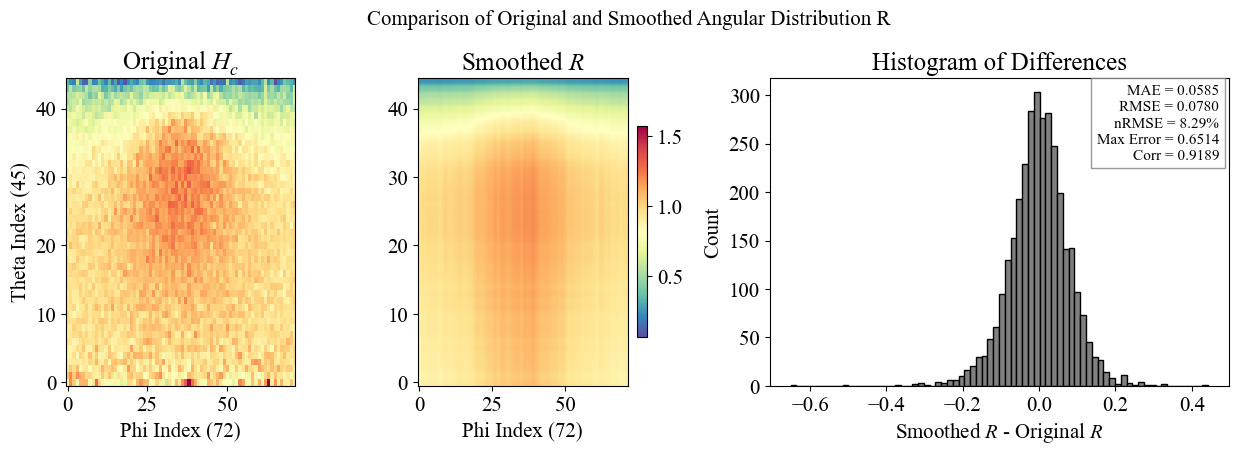

In [105]:
show_diff(H_c, R_phi_theta_approx1) # rank = 1

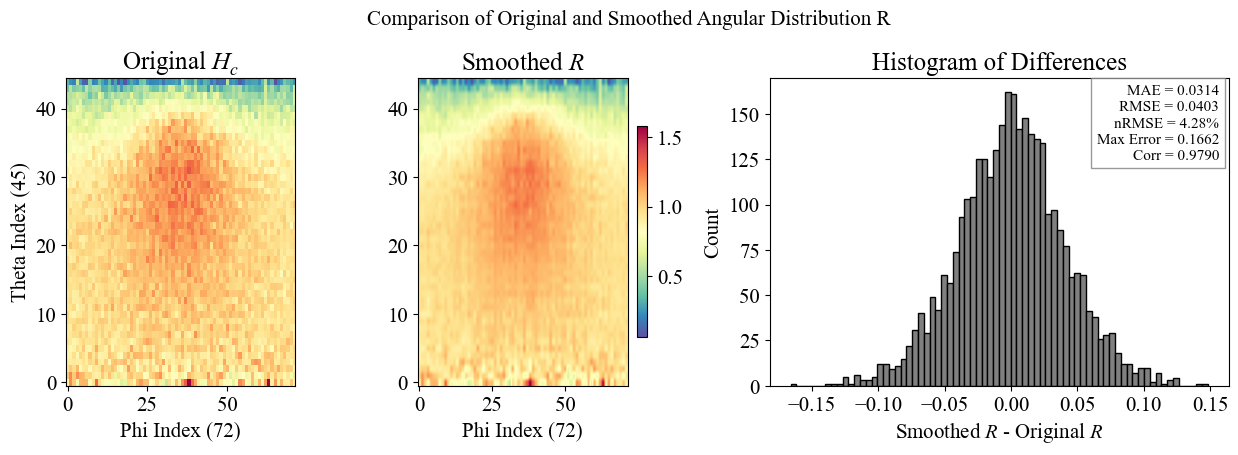

In [99]:
show_diff(H_c, R_phi_theta_approx) # 10 rank

# 4. Theory 
zenith, local zenith, relative azimuth, theta, phi, COD, rh, T, channel, 

### deposition H_theta

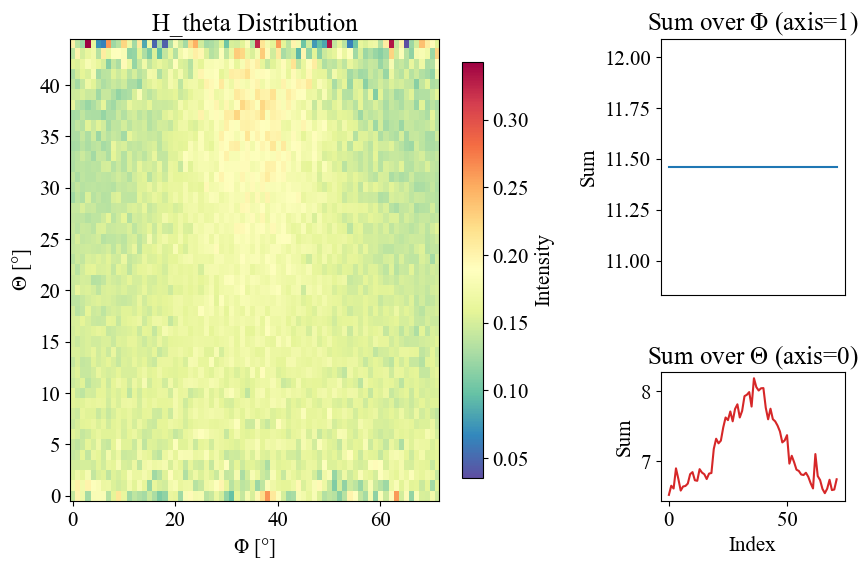

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# --- Dummy H_theta for example ---
# H_theta = np.random.rand(45, 72)  # shape (theta, phi)

# --- Font setup ---
font = 15
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = 'Times New Roman'

# --- Create figure with custom layout ---
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[2, 1])
gs.update(wspace=0.4, hspace=0.4)

# --- Figure 1: Heatmap ---
ax0 = fig.add_subplot(gs[:, 0])  # spans both rows
im = ax0.imshow(H_theta, cmap='Spectral_r', aspect='auto', origin='lower')
ax0.set_title("H_theta Distribution")
ax0.set_xlabel(r'$\Phi$ [°]')
ax0.set_ylabel(r'$\Theta$ [°]')
cbar = fig.colorbar(im, ax=ax0, shrink=0.9)
cbar.set_label("Intensity")

# --- Figure 2: Sum over φ (axis=1) ---
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(np.sum(H_theta, axis=1), color='tab:blue')
ax1.set_title("Sum over $\Phi$ (axis=1)")
ax1.set_ylabel("Sum")
ax1.set_xticks([])

# --- Figure 3: Sum over θ (axis=0) ---
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(np.sum(H_theta, axis=0), color='tab:red')
ax2.set_title("Sum over $\Theta$ (axis=0)")
ax2.set_xlabel("Index")
ax2.set_ylabel("Sum")

# --- Layout and show ---
plt.tight_layout()
plt.show()

A_theta_1 shape: (45,), B_phi_1 shape: (72,)
A_theta_2 shape: (45,), B_phi_2 shape: (72,)


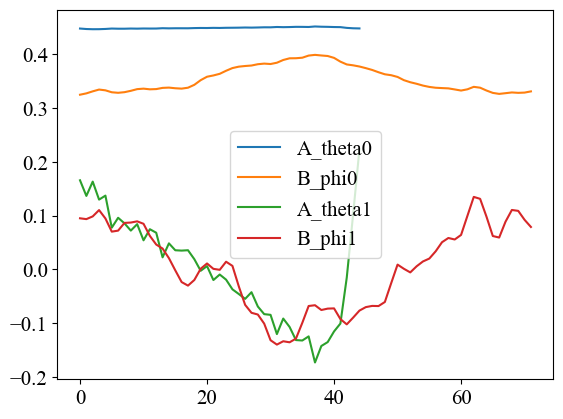

In [84]:
# R_phi_theta is your 2D matrix (shape: [n_theta, n_phi])
rank = 2  # you can change this
# 
R_phi_theta_approx, U_k, S_k, VT_k = svd_rank_k_approx(H_theta_s, rank=rank)

# Optional: Save each 1D component
A_list = [U_k[:, i] * np.sqrt(S_k[i, i]) for i in range(rank)]
B_list = [VT_k[i, :] * np.sqrt(S_k[i, i]) for i in range(rank)]
for i in range(rank):
    A_theta = A_list[i]
    B_phi = B_list[i]
    print(f"A_theta_{i+1} shape: {A_theta.shape}, B_phi_{i+1} shape: {B_phi.shape}")
    plt.plot(A_theta, label=f'A_theta{i}')
    plt.plot(B_phi, label=f'B_phi{i}')
plt.legend()
plt.show()


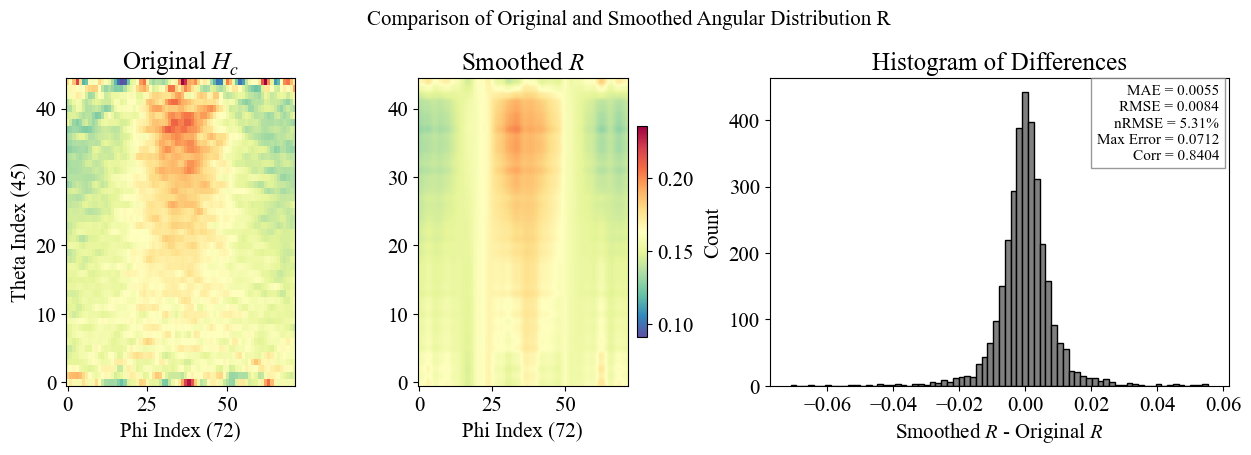

In [96]:
show_diff(H_theta_s, R_phi_theta_approx)

In [86]:
result = H_phi_intg_s[:, np.newaxis] * R_phi_theta_approx

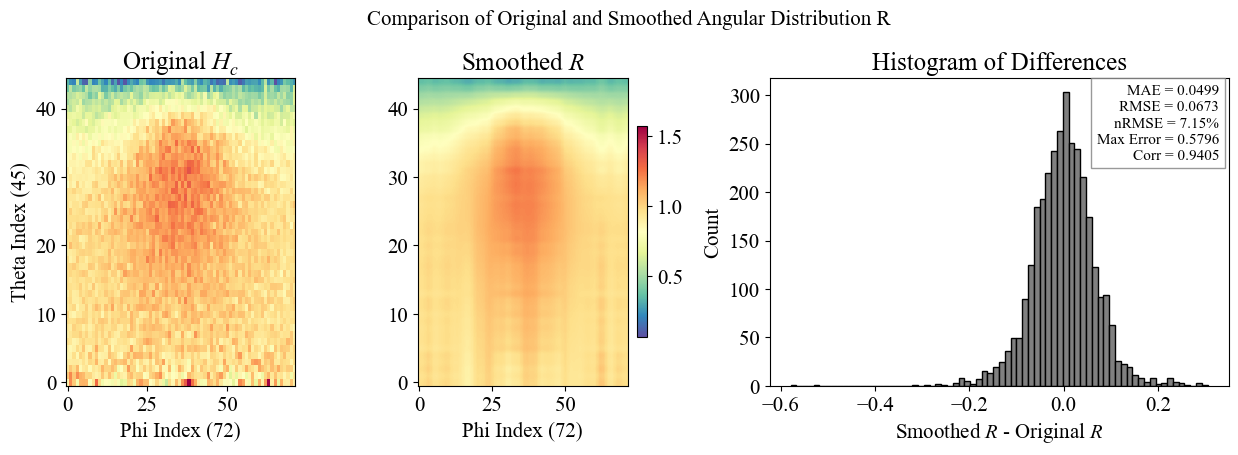

In [95]:
show_diff(H_c, result)

## Test for group 

In [4]:
d_th = 2
d_phi = 5
bins_theta = np.arange(0, 91, d_th)
bins_phi = np.arange(-180, 181, d_phi)

In [5]:
# Load the compressed file
data = np.load("Ang_D.npz")

# Rebuild the list
Ang_D = [data[f"D{i}"] for i in range(len(data.files))]
len(Ang_D)

30

### the consistent for Ang interpolation

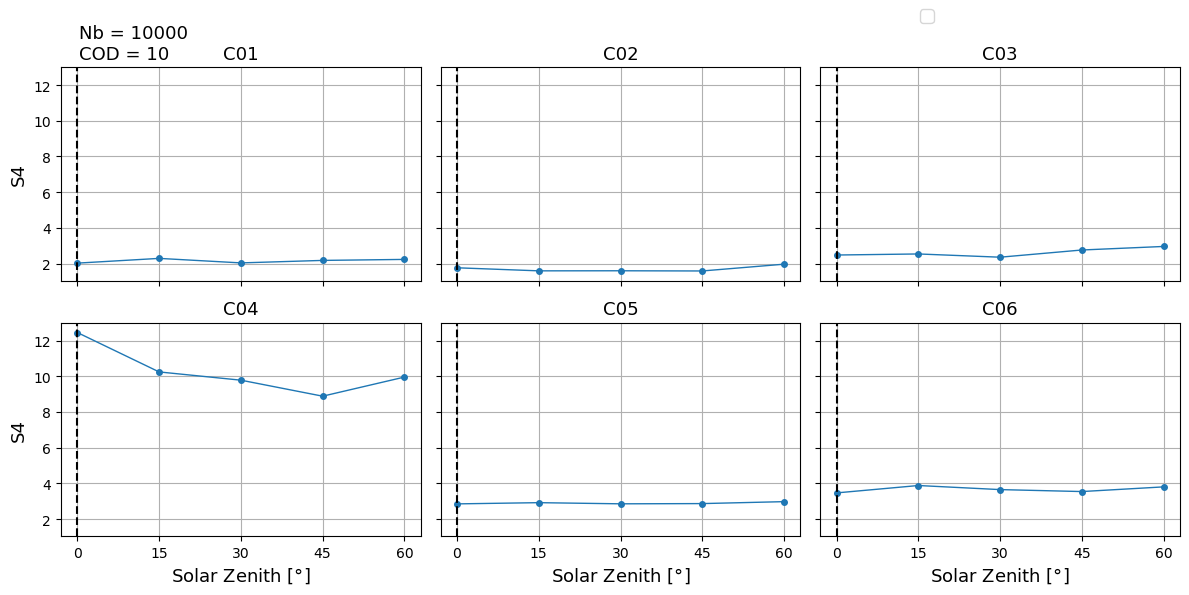

In [28]:
# Set up subplots for 6 channels
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.flatten()
Nb=10000
COD=10
font = 13
cos = False
n_angles=5
n_channels = 6
Ang = np.array([0, 15, 30, 45, 60])
lines = []
labels = []

markers = ['o', 's', '^', 'D', 'x']  # Circle, square, triangle, diamond, x

for c_idx, channel in enumerate(channels):
    ax = axs[c_idx]
    S = []  # Store singular values for each channel
    for i in range(5):
        # Each H_c is (phi_bins, theta_bins)
        H_c = Ang_D[i * n_channels + c_idx]
        #H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0)
        #H_theta_intg = H.T * np.deg2rad(d_theta)# / F_dw_os_srf[c_idx]  # integrate over theta

        rank = 5
        R_approx, U_k, S_k, VT_k = svd_rank_k_approx(H_c, rank=rank)
        # Optional: Save each 1D component
        A_list = [U_k[:, i] * np.sqrt(S_k[i, i]) for i in range(rank)]
        B_list = [VT_k[i, :] * np.sqrt(S_k[i, i]) for i in range(rank)]
        ii = rank-1
        mark = markers[ii % len(markers)]  # Cycle through markers
        A_theta = A_list[ii]
        B_phi = B_list[ii]
        S.append(S_k[ii, ii])
        #A_theta=gaussian_filter1d(A_theta,sigma=1)
        #l,=ax.plot(bins_theta[:-1],A_theta, label=f'A_theta{ii}', marker=mark, ms=3)
        #l,=ax.plot(bins_theta[:-1],A_theta, label=f'A_theta{ii}', marker=mark, ms=3)
        #B_phi=gaussian_filter1d(B_phi,sigma=1)
        #l,=ax.plot(bins_phi[:-1],B_phi, label=f'B_phi{ii}', marker=mark, ms=3)
        if c_idx == 0:
            #lines.append(l)
            labels.append(f'Z = {Ang[i]}')
    ax.plot(Ang,S,"o-", label=f'Singular value {ii+1}', markersize=4, linewidth=1)
    ax.set_title(channel, fontsize=font)
    # Only show y-labels for axs[0] and axs[3]
    if c_idx in [0, 3]:
        ax.set_ylabel(f'S{ii}', fontsize=font)

    # Only show x-labels for bottom row
    if c_idx in [3, 4, 5]:
        if cos:
            ax.set_xlabel(r'$\cos(\phi)$', fontsize=font)
        else:
            ax.set_xticks(Ang)
            ax.set_xlabel(r'Solar Zenith [$\degree$]', fontsize=font)
            #ax.set_xlabel(r'$\theta$ [$\degree$]', fontsize=font)

    ax.axvline(0, color='black', linestyle='--')
    ax.grid(True)

# Remove unused axes (if any)
for i in range(len(channels), len(axs)):
    fig.delaxes(axs[i])

# Global upper-left text
# fig.text(0.07, 0.98, f'Nb = {Nb}\nCOD = {COD}\nGauSm=1', fontsize=font,
#          ha='left', va='top', transform=fig.transFigure)
fig.text(0.07, 0.96, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
         ha='left', va='top', transform=fig.transFigure)

# Shared legend in upper-right of whole figure
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.79,1))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'./figures/AngularDisFuc/S{ii}_allcha.png',dpi=300, bbox_inches='tight')
plt.show()

### Method 1 SVD rank-k approximationm

Text(0.5, 1.0, 'RMSE for different smoothing levels')

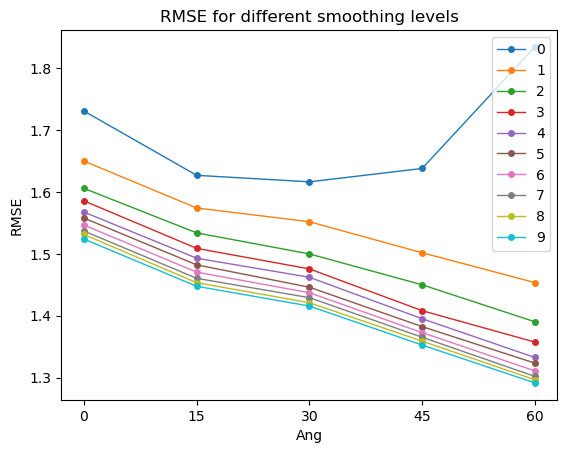

In [ ]:
for rank in range(10):
    plt.plot(Ang,RMSE_v[rank],label=f'{rank}', marker='o', markersize=4, linewidth=1)
plt.xlabel('Ang')
plt.xticks(Ang)
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE for different smoothing levels')
plt.savefig()

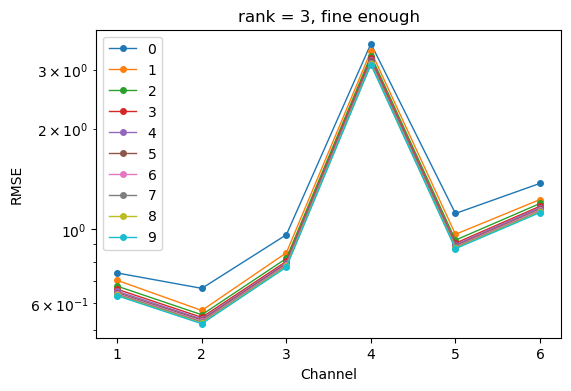

In [136]:
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()  # get current axis
for rank in range(10):
    ax.plot([1,2,3,4,5,6],RMSE_v[rank],label=f'{rank}', marker='o', markersize=4, linewidth=1)
ax.set_xlabel('Channel')
#plt.xtick(['C01', 'C02', 'C03', 'C04', 'C05', 'C06'])
ax.set_ylabel('RMSE')
ax.set_yscale('log')
ax.set_title('rank = 3, fine enough')
ax.legend()
fig.savefig(fig_dir+'USVT_3rank_channel_rmse.png', dpi=300, bbox_inches='tight')

plt.show()

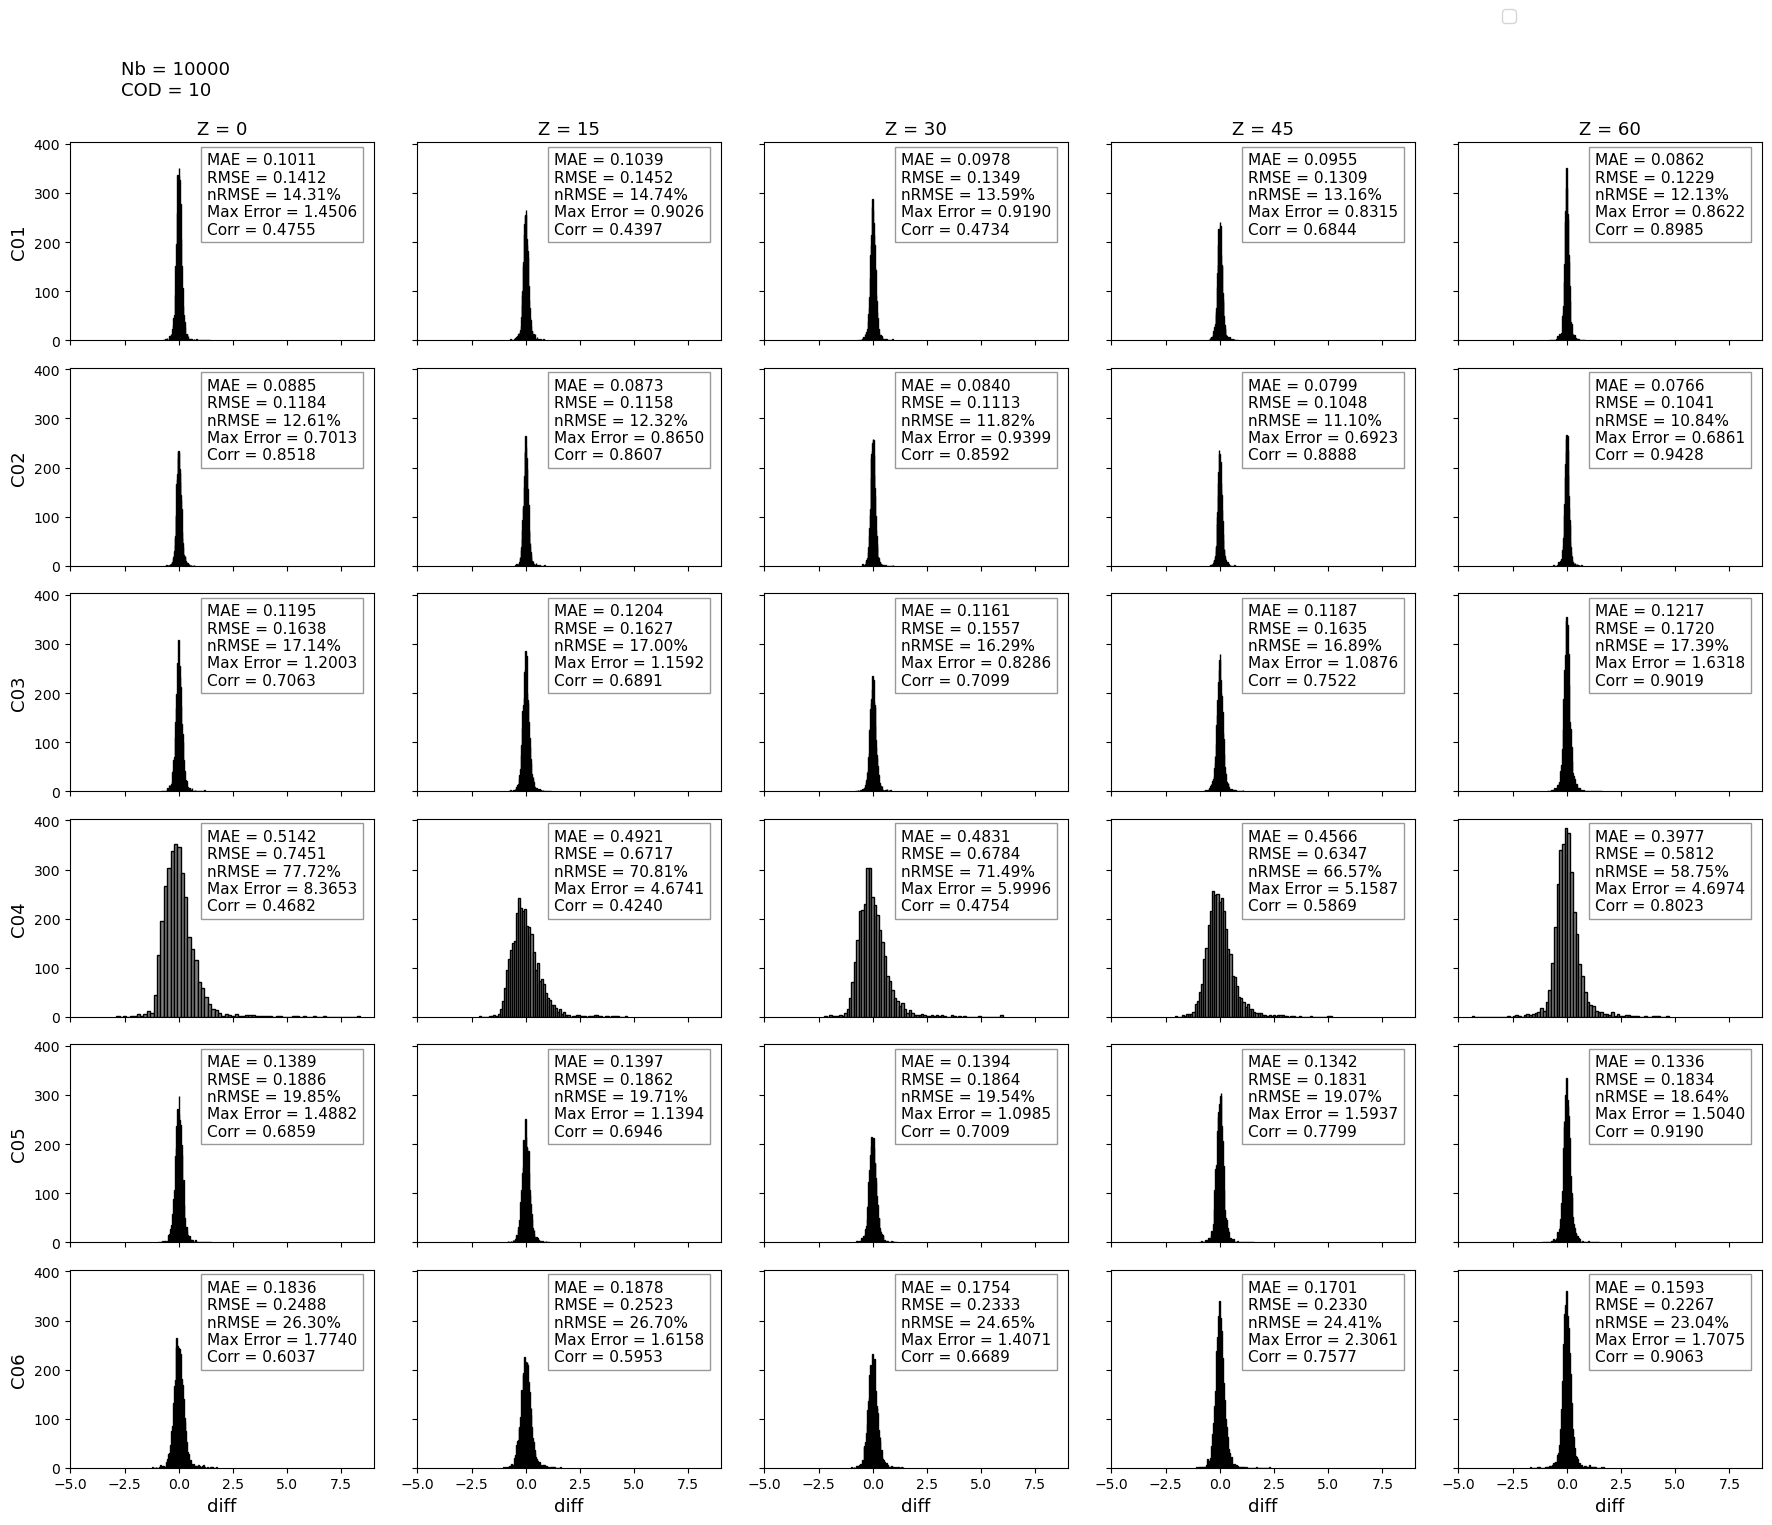

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from AngDistLUT import hism_diff, svd_rank_k_approx

font = 13
n_channels = 6
n_angles = 5
Nb=10000
COD=10
Ang = np.array([0, 15, 30, 45, 60])
markers = ['o', 's', '^', 'D', 'x']

fig, axs = plt.subplots(n_channels, n_angles, figsize=(18, 15), sharex=True, sharey=True)

labels = []
lines = []
#RMSE_v = []
rank = 3
for c_idx, channel in enumerate(channels):
    for i in range(n_angles):
        ax = axs[c_idx, i]
        H_c = Ang_D[i * n_channels + c_idx]  # Each H_c: (phi_bins, theta_bins)    
        R_approx, U_k, S_k, VT_k = svd_rank_k_approx(H_c, rank=rank, Gau_smooth=True)

    # Plot the histogram difference on this subplot
        l = hism_diff(R_approx, H_c,  ax=ax)
    # RMSE.append(rmse)
    # RMSE_v.append(RMSE)
        if c_idx == 0:
                labels.append(f'Z = {Ang[i]}')
                lines.append(l)
        if c_idx == 0:
            ax.set_title(f'Z = {Ang[i]}', fontsize=font)

        if i == 0:
            ax.set_ylabel(channel, fontsize=font)
        if c_idx == n_channels - 1:
            ax.set_xlabel(r'diff', fontsize=font)
    
# Global annotation
fig.text(0.07, 0.98, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
        ha='left', va='top', transform=fig.transFigure)

# Shared legend
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.85, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig_dir = 'figures/'
#fig.savefig(fig_dir+'USVT_3rank_repretest.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
R_approx.shape

(45, 72)

#### method 2 : not better than method 1

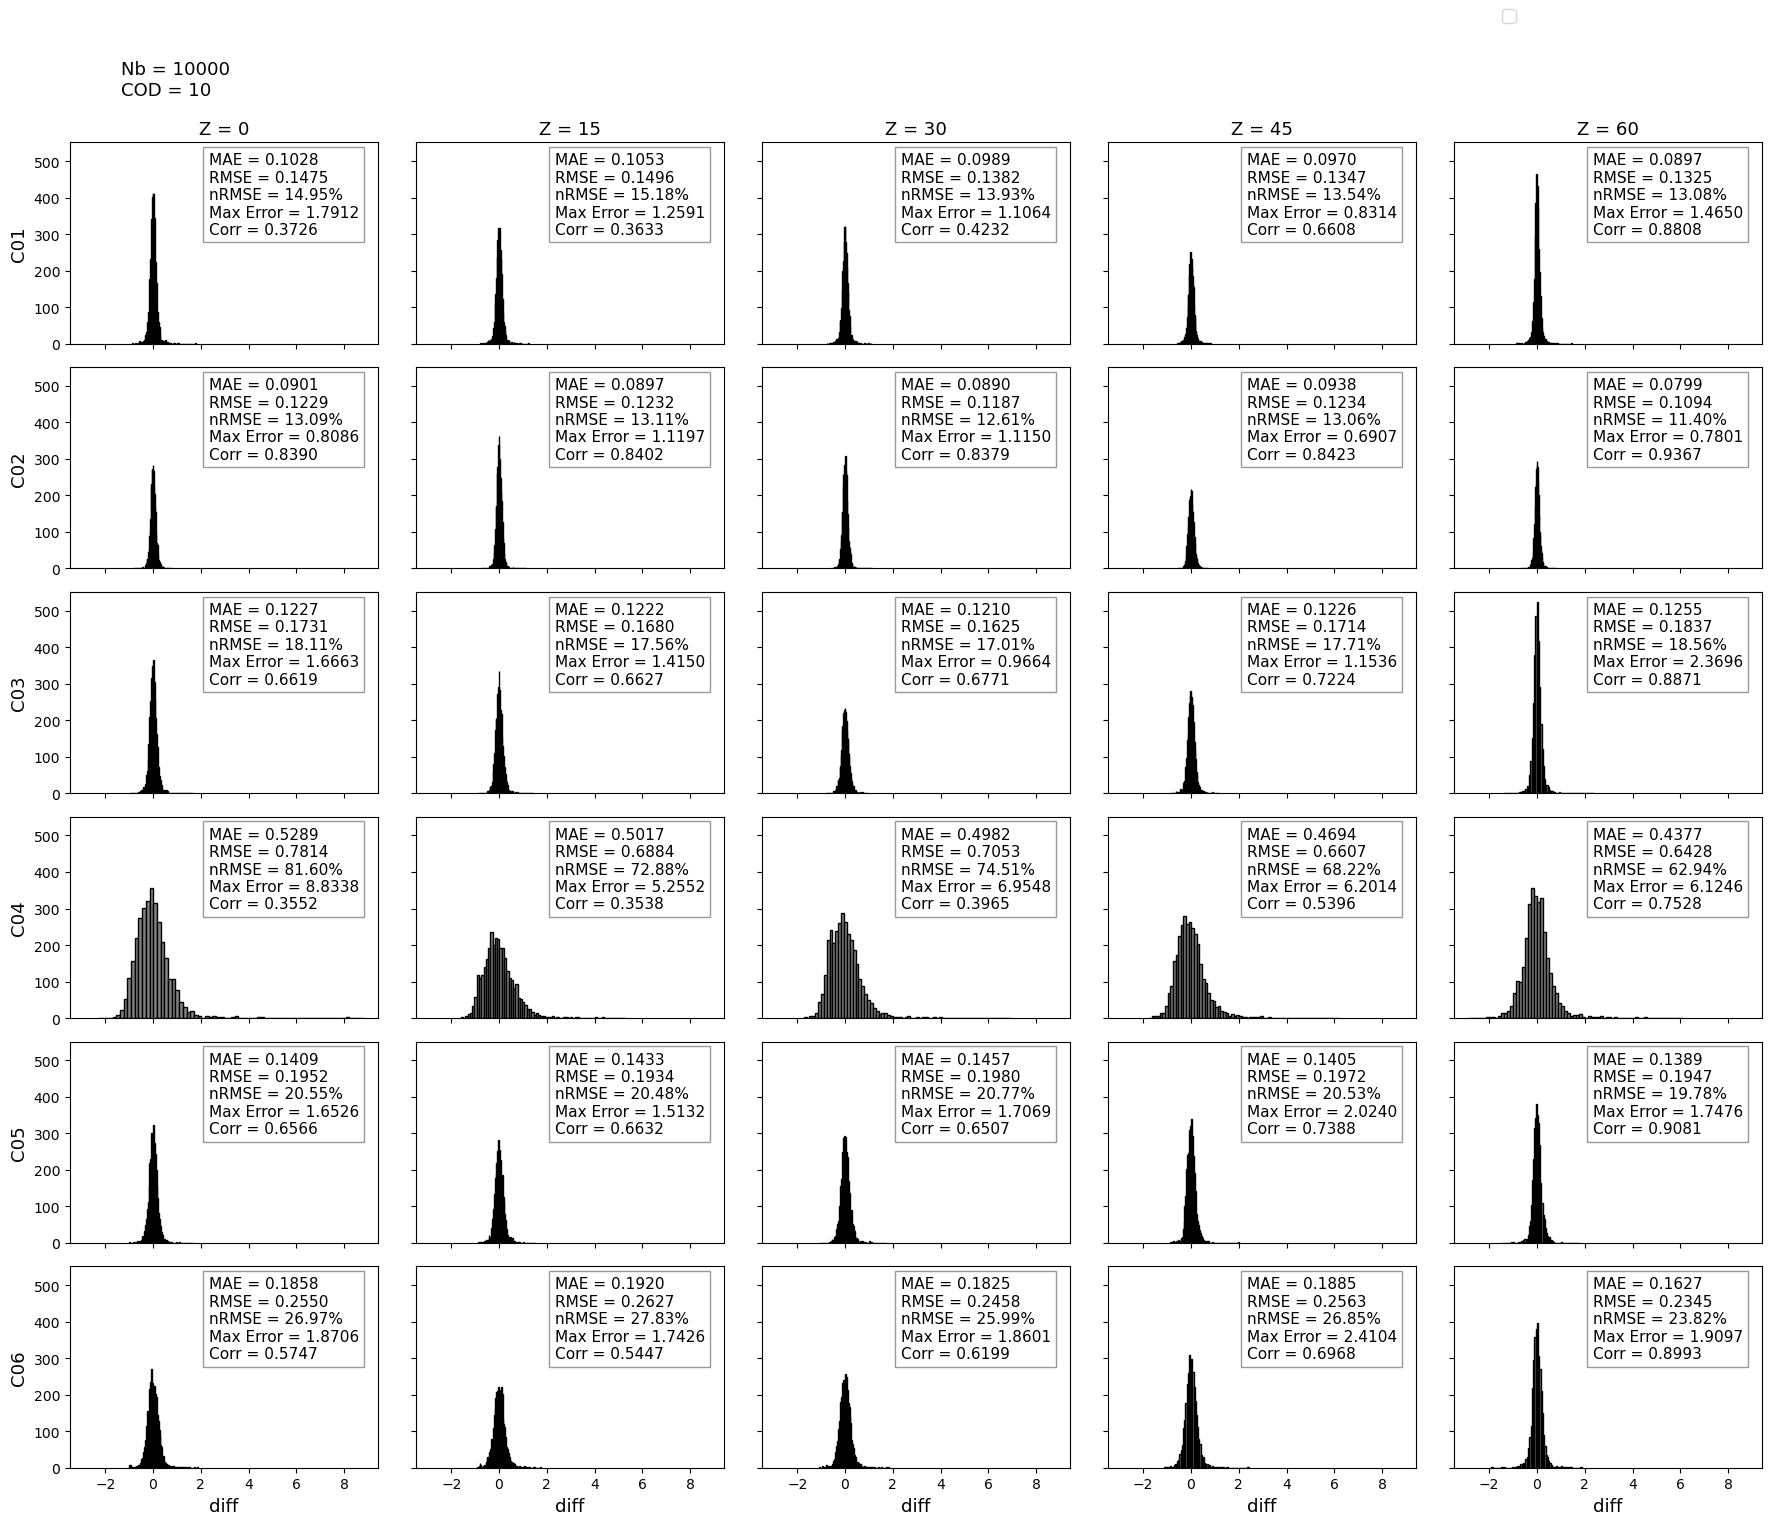

In [139]:
import numpy as np
import matplotlib.pyplot as plt

font = 13
n_channels = 6
n_angles = 5
Ang = np.array([0, 15, 30, 45, 60])
markers = ['o', 's', '^', 'D', 'x']

fig, axs = plt.subplots(n_channels, n_angles, figsize=(18, 15), sharex=True, sharey=True)

labels = []
lines = []
#RMSE_v = []

for c_idx, channel in enumerate(channels):
    for i in range(n_angles):
        ax = axs[c_idx, i]
        H_c = Ang_D[i * n_channels + c_idx]  # Each H_c: (phi_bins, theta_bins)  
        # H_phi_intg is a 1D NumPy array
        H_phi_intg = np.sum(H_c, axis=1) * np.deg2rad(d_phi)
        H_phi_intg_s = gaussian_filter1d(H_phi_intg, sigma=1)

        # USVT method
        H_theta = H_c / H_phi_intg[:, np.newaxis]
        rank = 2
        H_theta_Gm, U_k, S_k, VT_k = svd_rank_k_approx(H_theta, rank=rank, Gau_smooth=True)

        # back
        R_approx = H_phi_intg_s[:, np.newaxis] * H_theta_Gm  
        l = hism_diff(R_approx, H_c,  ax=ax)
    # RMSE.append(rmse)
    # RMSE_v.append(RMSE)
        if c_idx == 0:
                labels.append(f'Z = {Ang[i]}')
                lines.append(l)
        if c_idx == 0:
            ax.set_title(f'Z = {Ang[i]}', fontsize=font)

        if i == 0:
            ax.set_ylabel(channel, fontsize=font)
        if c_idx == n_channels - 1:
            ax.set_xlabel(r'diff', fontsize=font)
    
# Global annotation
fig.text(0.07, 0.98, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
        ha='left', va='top', transform=fig.transFigure)

# Shared legend
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.85, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig_dir = 'figures/'
fig.savefig(fig_dir+'USVT_3rank_repretest_method2.png', dpi=300, bbox_inches='tight')
plt.show()

In [132]:
from scipy.ndimage import gaussian_filter1d

def svd_rank_k_approx(matrix, rank=2, Gau_smooth = True):
    """
    Perform a rank-k approximation of a 2D matrix using SVD.

    Parameters:
        matrix (ndarray): Input 2D array (e.g. R(phi|theta))
        rank (int): Desired rank for approximation

    Returns:
        matrix_approx (ndarray): Rank-k approximated matrix
        U_k (ndarray): Left singular vectors (truncated)
        S_k (ndarray): Singular values (truncated)
        VT_k (ndarray): Right singular vectors (truncated)
    """
    U, S, VT = np.linalg.svd(matrix, full_matrices=False)

    U_k = U[:, :rank]
    S_k = np.diag(S[:rank])
    VT_k = VT[:rank, :]
    if Gau_smooth:
    # Apply Gaussian smoothing to each singular vector (column of U_k, row of VT_k)
        U_k = np.array([gaussian_filter1d(U_k[:, i], sigma=1) for i in range(rank)]).T  # shape: (n_samples, rank)
        VT_k = np.array([gaussian_filter1d(VT_k[i, :], sigma=1) for i in range(rank)])  # shape: (rank, n_features)

    matrix_approx = U_k @ S_k @ VT_k
    return matrix_approx, U_k, S_k, VT_k


def hism_diff(H_c, result, ax):
    # --- Your metrics calculations ---
    mae = np.mean(np.abs(result - H_c))
    rmse = np.sqrt(np.mean((result - H_c)**2))
    nrmse = rmse / np.mean(H_c) *100
    max_err = np.max(np.abs(result - H_c))
    corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

    # --- Shared color limits for imshow ---
    vmin = min(H_c.min(), result.min())
    vmax = max(H_c.max(), result.max())

    diff = (result - H_c).flatten()
    l = ax.hist(diff, bins=72, color='gray', edgecolor='black')
    #ax.set_title("Histogram of Differences")
    #ax.set_xlabel("Smoothed $R$ - Original $R$")
    #ax.set_ylabel("Count")

    # --- Add metrics as text box on the histogram ---
    metrics_text = (
        f"MAE = {mae:.4f}\n"
        f"RMSE = {rmse:.4f}\n"
        f"nRMSE = {nrmse:.2f}%\n"
        f"Max Error = {max_err:.4f}\n"
        f"Corr = {corr:.4f}"
    )
    # Place text in the upper right of the histogram axes
    ax.text(0.45, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=11, va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    fig_dir = 'figures/'
    #fig.savefig(fig_dir+'Smooth_R_2D.png', dpi=300, bbox_inches='tight')
    # plt.suptitle("Comparison of Original and Smoothed Angular Distribution R", fontsize=15, y=1.05)
    # plt.tight_layout()
    # plt.show()


### smooth 

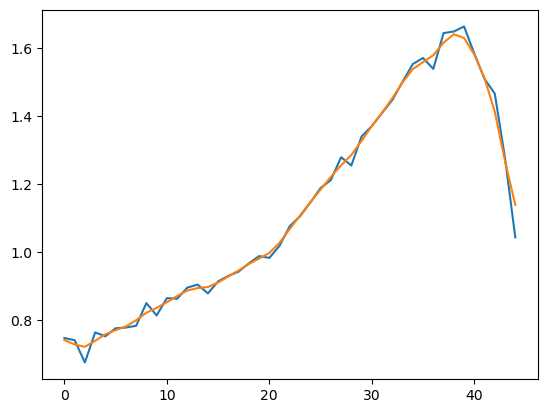

In [60]:
# Smooth along axis 1 (phi), keep theta rows unchanged
#plt.plot(np.sum(H_theta_intg,axis=0))
# H_theta_smooth = gaussian_filter1d(H_theta_intg, sigma=1, axis=1,mode='reflect')
# plt.plot(np.sum(H_theta_smooth,axis=0))
plt.plot(A_theta)
U_=gaussian_filter1d(A_theta,sigma=1,)
plt.plot(U_)

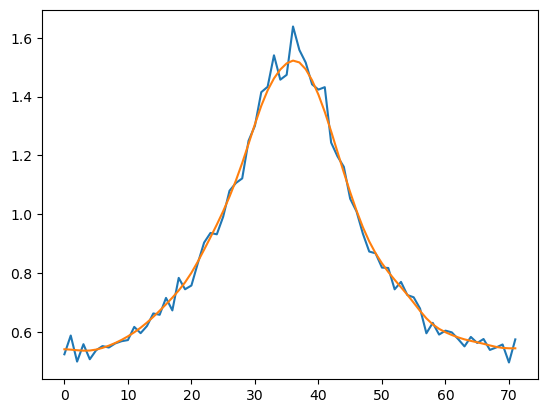

In [63]:
plt.plot(B_phi)
V_=gaussian_filter1d(B_phi,sigma=2,mode='reflect')
plt.plot(V_)

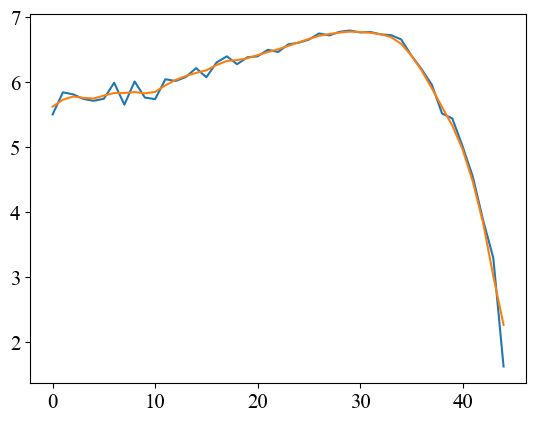

In [100]:
plt.plot(H_phi_intg)
from scipy.ndimage import gaussian_filter1d

# H_phi_intg is a 1D NumPy array
H_phi_smooth = gaussian_filter1d(H_phi_intg, sigma=1)
plt.plot(H_phi_smooth)

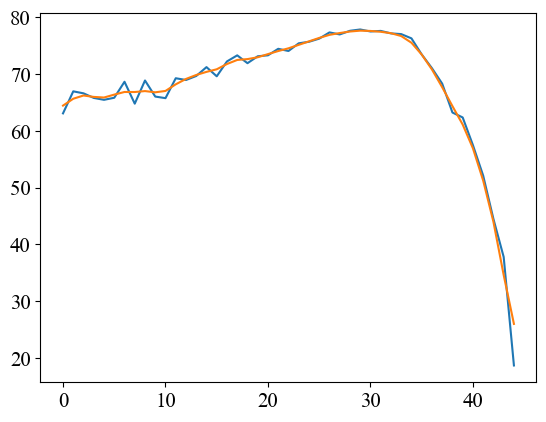

In [138]:
plt.plot(np.sum(H_c,axis=1))
plt.plot(np.sum(result,axis=1))

# 5. Theory test

In [6]:
from fun_nearealtime_RTM import nearealtime_RTM
#from AngDistLUT import saveLUT 
channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
COD_v = np.array([10])
#np.concatenate([np.linspace(0,20,11),np.linspace(25,50,6)])
Sun_Zen_v = np.array([30]) # 0,15,30,45,60
T_a = 294
bandmode_v = ['channels']
rh0_v = np.array([60])#/100
N_bundles = 10000
Ang_D = []
H_v = []
for iCOD in COD_v:
    iCOD = int(iCOD)
    for ang in Sun_Zen_v:
        for ch_idx, channel in enumerate(channels):
            fdir = "/mnt/dengnan/RTM_10000/"
            #fdir = "/Volumes/DN1T_SSD/data/RTM_10000/"
            filename = '/' + f'uwxyzr_COD={iCOD}_th0={ang}_Ta=294_RH=30.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = fy_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = fy_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    H, R_c = cal_mono_R(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=1.6
                    #ghi2d_show(R_c, channel, iCOD, vmax)
                    # H_theta = np.sum(H_c, axis=1)
                    Ang_D.append(R_c)
                    H_v.append(H)

In [7]:
R_c.shape

(45, 72)

In [8]:
H_v

[29.980380251187942,
 49.20465397237619,
 16.009273746726677,
 0.38534110211980555,
 4.6603557555996495,
 1.017856729189048]

In [9]:
ang=3
RH=30
uw = get_RTM_usw(ang, iCOD, T_a, RH)

In [13]:
channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
nu0 = np.arange(2500, 35000, 3)  # Wavenumber grid
nu_channels = fy_calinu(nu0, channels, "./GOES_data/", dnu=3)
df = pd.DataFrame(columns=channels)


for channel in channels:
    # load calibration data : Spectral Response Func
    channel_number = int(channel[-2:])
    sensor = 'GOES16'
    if sensor == 'GOES16':
        dirpath = file_dir + 'abi_calibration/'
        channel_srf = os.path.join(dirpath,
                                   'GOES-R_ABI_PFM_SRF_CWG_ch{:d}.txt'.format(channel_number))
    else:
        dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
        channel_srf = os.path.join(
            dirpath,
            'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number)
        )
    calibration = np.genfromtxt(channel_srf, skip_header=2)
    calibration_nu = calibration[:, 1]  # cm-1
    calibration_srf = calibration[:, 2]  # relative SRF [-]
    nu_channel = fy_calinu(nu0, [channel], file_dir, dnu=3)
    calibration_nu = calibration_nu[::-1]
    calibration_srf = calibration_srf[::-1]
    srf = np.interp(nu_channel, calibration_nu, calibration_srf)
    nu_idx = np.nonzero(np.isin(nu_channels, nu_channel))[0]  # fixed 1 April.
    # correct uw
    uw_cor = np.multiply(uw[nu_idx], srf)
    uw_channel = np.trapz(uw_cor,nu_channel)
    df.loc[0, channel] = uw_channel#/np.pi * H_r[theta_idx, phi_idx]

In [14]:
df

C01        C02        C03       C04       C05       C06
0  27.877255  44.876142  15.137455  0.341124  4.366062  0.922709